In [1]:
import numpy as np
import pandas as pd
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.spatial as scs
import scipy as sc
import math
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import r2_score
from random import randrange

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
50 5.0 10.0 
50 5.0 10.0 
25 5.0 10.0

In [3]:
varmodelpar = '''                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
varmodel.out                 -file for modeled variogram points output
2                            -number of directions to model points along
  45   0.0  1000   0.5      -  azm, dip, npoints, point separation
 135   0.0  1000   0.5      -  azm, dip, npoints, point separation
1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)
0   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
varcalc.out                  -    experimental output file 1
2   1   4                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
varmodelfit.var              -  file to save fit variogram model
'''
varmodel= gs.Program(program='varmodel',parfile='varmodel.par')
varmodel.run(parstr=varmodelpar.format())
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

Calling:  ['varmodel', 'varmodel.par']

varmodel version: 1.1.1

  output points file: varmodel.out
  number of directions to model points along:            2
  azm, dip, npoints, pointsep:    45.0000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:    135.000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  nst =           1
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            0      100000
  number of variogram files:            1
  variogram file: varcalc.out
  using variograms            1           4
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output file: varmodelfit.var
  Modeling points

varmodel completed successfully

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \


In [4]:
varmodelfl = gs.DataFile(flname='varmodel.out',
                       readfl=True)
print(varmodelfl.data.head())

   Variogram Index  Lag Distance  Number of Pairs  Variogram Value  \
0              1.0           0.5              1.0         0.010012   
1              1.0           1.0              1.0         0.010047   
2              1.0           1.5              1.0         0.010107   
3              1.0           2.0              1.0         0.010190   
4              1.0           2.5              1.0         0.010297   

   Variogram Number  Calculation Azimuth  Calculation Dip  
0               1.0                 45.0              0.0  
1               1.0                 45.0              0.0  
2               1.0                 45.0              0.0  
3               1.0                 45.0              0.0  
4               1.0                 45.0              0.0  


In [5]:
varg = ("1    0.01                   -nst, nugget effect\n\
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)\n\
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)")

print(varg)

1    0.01                   -nst, nugget effect
3    0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        250    250    150    -a_hmax, a_hmin, a_vert (ranges)


In [6]:
sgsimpar = '''                  Parameters for SGSIM
                  ********************

START OF PARAMETERS:
cluster.dat           -file with data
1  2  3  4  0  0              -  columns for X,Y,Z,vr,wt,sec.var.
-1.0       1.0e21             -  trimming limits
0                             -transform the data (0=no, 1=yes)
sgsim.trn                     -  file for output trans table
0                             -  consider ref. dist (0=no, 1=yes)
histsmth.out                  -  file with ref. dist distribution
1  2                          -  columns for vr and wt
0.0    15.0                   -  zmin,zmax(tail extrapolation)
1       0.0                   -  lower tail option, parameter
1      15.0                   -  upper tail option, parameter
1                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output
sgsim.out                     -file for simulation output
1                             -number of realizations to generate
{grid}
69069                         -random number seed
0     8                       -min and max original data for sim
48                            -number of simulated nodes to use
1                             -assign data to nodes (0=no, 1=yes)
1     3                       -multiple grid search (0=no, 1=yes),num
0                             -maximum data per octant (0=not used)
250  250.0  150.0              -maximum search radii (hmax,hmin,vert)
 0.0   0.0   0.0              -angles for search ellipsoid
51    51    11                -size of covariance lookup table
0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC
../data/ydata.dat             -  file with LVM, EXDR, or COLC variable
4                             -  column for secondary variable
{varg}

'''
sgsim= gs.Program(program='sgsim',parfile='sgsim.par')
sgsim.run(parstr=sgsimpar.format(varg = varg,
                                 grid = griddef
                                ))
sgsimfl = gs.DataFile(flname='sgsim.out', griddef = griddef,
                       readfl=True)
print(sgsimfl.data.head())

Calling:  ['sgsim', 'sgsim.par']

 SGSIM Version: 4.000

  data file = cluster.dat                             
  input columns =            1           2           3           4           0
           0
  trimming limits =   -1.000000      1.0000000E+21
  transformation flag =            0
  transformation file = sgsim.trn                               
  consider smoothed distribution (1=yes) =            0
  file with smoothed distribution = histsmth.out                            
  columns =            1           2
  data limits (tails) =   0.0000000E+00   15.00000    
  lower tail =            1  0.0000000E+00
  upper tail =            1   15.00000    
  debugging level =            1
  debugging file = sgsim.dbg                               
  output file sgsim.out                               
  number of realizations =            1
  X grid specification =           50   5.000000       10.00000    
  Y grid specification =           50   5.000000       10.00000    
  Z grid

In [7]:
sgsimfl = gs.DataFile(flname='sgsim.out', griddef = griddef,
                       readfl=True)
print(sgsimfl.data.describe())

              value
count  62500.000000
mean       0.371670
std        0.775798
min       -2.018213
25%       -0.209773
50%        0.321934
75%        0.889074
max        2.813831


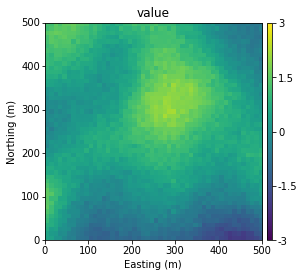

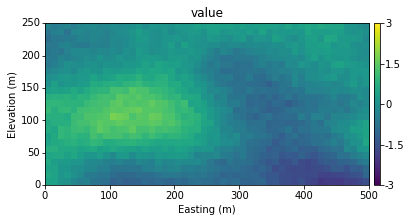

In [8]:
vlim = (-3,3)
gs.pixelplt(sgsimfl,griddef,orient='xy', vlim = vlim)
gs.pixelplt(sgsimfl,griddef,orient='xz', vlim = vlim)


In [9]:
addcoordpar = '''                  Parameters for ADDCOORD
                  ***********************

START OF PARAMETERS:
{datafl}                         -file with data
addcoord.out                      -file for output
1                                 -realization number
{grid}
3 3 6                            -decimals for x, y, z (-1=exclude)
'''
addcoord= gs.Program(program='addcoord',parfile='addcoord.par')
addcoord.run(parstr=addcoordpar.format(datafl=sgsimfl.flname
                                ,grid = griddef
                                ))
addcoordfl = gs.DataFile(flname='addcoord.out', griddef = griddef,
                       readfl=True)
print(addcoordfl.data.head())

Calling:  ['addcoord', 'addcoord.par']

 ADDCOORD VERSION: 4.1.0

 Data File = sgsim.out                               
 Output File = addcoord.out                            
 Realization number =            1
 X grid size =           50   5.00000000000000        10.0000000000000     
 Y grid size =           50   5.00000000000000        10.0000000000000     
 Z grid size =           25   5.00000000000000        10.0000000000000     
 decimals =            3           3           6
 
 Format: (f07.03,x,f07.03,x,f10.06,x,a)      

 ADDCOORD: 4.1.0 Finished

      X    Y    Z     value
0   5.0  5.0  5.0  0.482893
1  15.0  5.0  5.0  0.435116
2  25.0  5.0  5.0  0.116569
3  35.0  5.0  5.0  0.084204
4  45.0  5.0  5.0 -0.211761


In [10]:
datafl = gs.DataFile(flname = 'addcoord.out',x='X',y='Y',z='Z', griddef=griddef,
readfl=True)
print(datafl.data.head())

      X    Y    Z     value
0   5.0  5.0  5.0  0.482893
1  15.0  5.0  5.0  0.435116
2  25.0  5.0  5.0  0.116569
3  35.0  5.0  5.0  0.084204
4  45.0  5.0  5.0 -0.211761


In [11]:
gs.write_gslib(datafl,'addcoord.out')


In [12]:
datafl = gs.DataFile(flname ='addcoord.out',x='X',y='Y',z='Z', griddef=griddef,
readfl=True)

In [13]:
datafl.rename({'value': 'Var1'})

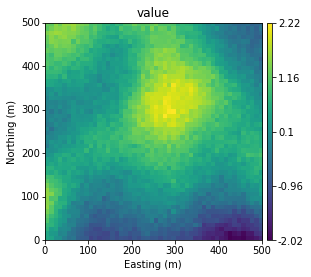

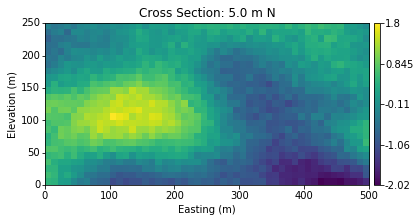

In [14]:
gs.pixelplt(sgsimfl,griddef)
gs.pixelplt(datafl['Var1'], griddef = griddef, orient='xz')

In [15]:
gsamplepar = '''       Parameters for gsample V2.000
     *********************************
       
START OF PARAMETERS:
1                            - Number of files to sample
{datafl}            - File with first grid
1  {varcol1}                        - Number of variables and columns
1                            - Realization to sample
{griddef}
0                            - Sampling spacing option (0=regular, 1=random)
100  100                       -  If 0, spacing in X, Y
50  50                     -  If 0, collar of the first sample, X and Y (inside sampling grid)
80  69069                    -  If 1, number of drill holes and seed number
0  90                        - Azimuth and dip
10                            - Sample spacing downhole
1                          - Starting drill hole ID for new drills
2                            - Number of decimal places (coordinates precision, up to 6)
5   495                       - Sampling grid: xmin, xmax
5   495                       -                ymin, ymax
5   245                       -                zmin, zmax
dhs.out        - Output file with new drill holes
0                            - Output keyout file? (0=no, 1=yes)
0                            -  If keyout (0=input grid inside sampling grid, 1=input blocks with assays)
keyout.out         - Keyout file
'''
gsample= gs.Program(program='gsample',parfile='gsample.par')
gsample.run(parstr=gsamplepar.format(datafl=datafl.flname,
                                       varcol1=datafl.gscol('Var1'),
                                         griddef=griddef
                                      ))

Calling:  ['gsample', 'gsample.par']

GSAMPLE Version: 1.000

PARAMETER FILE                  = gsample.par                                                                                                                                                                                                                                                     
-----------------------------------------------------------------------------

INPUT PARAMETERS 

Number of grids to sample       =   1
Total number of variables       =   1
 
Data file  1                    = 
addcoord.out
Variable columns                =   4
 
Sample realization number       =   1
 
Input grid 
Input grid in X                 =   50        5.00   10.00
Input grid in Y                 =   50        5.00   10.00
Input grid in Z                 =   25        5.00   10.00
 
Sample option                   =   0
 
Consider regular spacing 

 
Spacing in X                    =   100.0    
Spacing in Y                    =   1

In [16]:
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
print(dataflpoints.data.head())
dataflpoints.describe()

   Drill ID     X     Y      Z    MD  Block ID   value
0       1.0  50.0  50.0  245.0   0.0   60256.0 -0.2301
1       1.0  50.0  50.0  235.0  10.0   57756.0 -0.1845
2       1.0  50.0  50.0  225.0  20.0   55256.0 -0.1333
3       1.0  50.0  50.0  215.0  30.0   52756.0 -0.0725
4       1.0  50.0  50.0  205.0  40.0   50256.0 -0.0517


Drill ID          MD      Block ID       value
count  600.000000  600.000000    600.000000  600.000000
mean    13.000000  115.000000  32526.000000    0.367402
std      7.217119   69.279623  17334.363759    0.762382
min      1.000000    0.000000   2756.000000   -1.088800
25%      7.000000   57.500000  17641.000000   -0.178750
50%     13.000000  115.000000  32526.000000    0.329350
75%     19.000000  172.500000  47411.000000    0.918200
max     25.000000  230.000000  62296.000000    2.652200

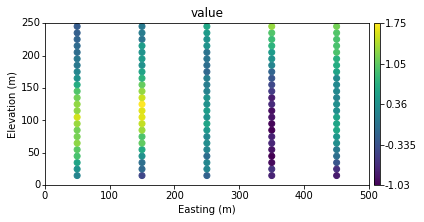

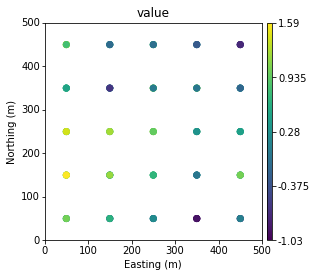

In [17]:
gs.locmap(dataflpoints,var = 'value',orient='xz')
gs.locmap(dataflpoints,var = 'value',orient='xy')

In [18]:
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl['Z'] = datasamplefl['Z']

In [19]:
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()

X           Y           Z       value
count  600.000000  600.000000  600.000000  600.000000
mean   250.000000  250.000000  130.000000    0.367402
std    141.539352  141.539352   69.279625    0.762382
min     50.000000   50.000000   15.000000   -1.088800
25%    150.000000  150.000000   72.500000   -0.178750
50%    250.000000  250.000000  130.000000    0.329350
75%    350.000000  350.000000  187.500000    0.918200
max    450.000000  450.000000  245.000000    2.652200

In [20]:
gs.write_gslib(datasamplefl, 'datasamplefl.out')

In [21]:
datatest = np.asarray(datasamplefl)

In [22]:
if 'sess' in locals() and sess is not None:
    print('Close interactive session')
    sess.close()

In [23]:
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

-1.0888
2.6522
1
Working on Node 15 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp6f3_xl_h', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E3E7EEEBE0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Queue-based input pipelines have

Epoch: 800/5000 err = 0.023027198389172554
Cost_test : 0.024243407
R^2:0.5191919207572937
Epoch: 900/5000 err = 0.023755332455039024
Cost_test : 0.02246511
R^2:0.4541558623313904
Epoch: 1000/5000 err = 0.020619630813598633
Cost_test : 0.021070095
R^2:0.5068334341049194
Epoch: 1100/5000 err = 0.01692403480410576
Cost_test : 0.020004602
R^2:0.590459406375885
Epoch: 1200/5000 err = 0.016598325222730637
Cost_test : 0.019018553
R^2:0.6129229068756104
Epoch: 1300/5000 err = 0.01706567592918873
Cost_test : 0.01824366
R^2:0.6341652274131775
Epoch: 1400/5000 err = 0.016275905072689056
Cost_test : 0.017567579
R^2:0.6218060255050659
Epoch: 1500/5000 err = 0.015556800179183483
Cost_test : 0.01697704
R^2:0.6475310921669006
Epoch: 1600/5000 err = 0.014263952150940895
Cost_test : 0.016468095
R^2:0.6436976194381714
Epoch: 1700/5000 err = 0.015186169184744358
Cost_test : 0.015880471
R^2:0.6604838967323303
Epoch: 1800/5000 err = 0.013910891488194466
Cost_test : 0.015463791
R^2:0.6852415800094604
Epoch: 

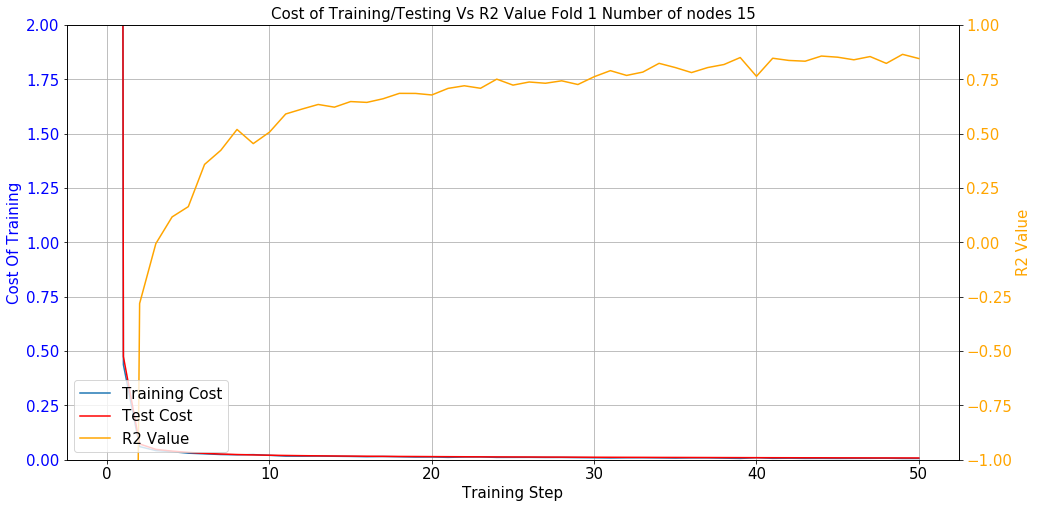

Working on Node 20 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpf5tezryk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E400274748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.0071280221454799175
Cost_test : 0.008722196
R^2:0.8220582008361816
Epoch: 1200/5000 err = 0.006726676598191261
Cost_test : 0.008278521
R^2:0.8485809564590454
Epoch: 1300/5000 err = 0.006682888139039278
Cost_test : 0.007853654
R^2:0.8412603139877319
Epoch: 1400/5000 err = 0.005777944810688496
Cost_test : 0.007456442
R^2:0.8703509569168091
Epoch: 1500/5000 err = 0.0061425152234733105
Cost_test : 0.007131522
R^2:0.8617882132530212
Epoch: 1600/5000 err = 0.005403886549174786
Cost_test : 0.0068473155
R^2:0.8814542889595032
Epoch: 1700/5000 err = 0.0048837424255907536
Cost_test : 0.0065162703
R^2:0.8850520849227905
Epoch: 1800/5000 err = 0.005178628955036402
Cost_test : 0.0062580663
R^2:0.8828359842300415
Epoch: 1900/5000 err = 0.004583335481584072
Cost_test : 0.006049336
R^2:0.9027647972106934
Epoch: 2000/5000 err = 0.004850960802286863
Cost_test : 0.0058073485
R^2:0.8762276768684387
Epoch: 2100/5000 err = 0.005213350988924503
Cost_test : 0.0055713863
R^2:0.88878732

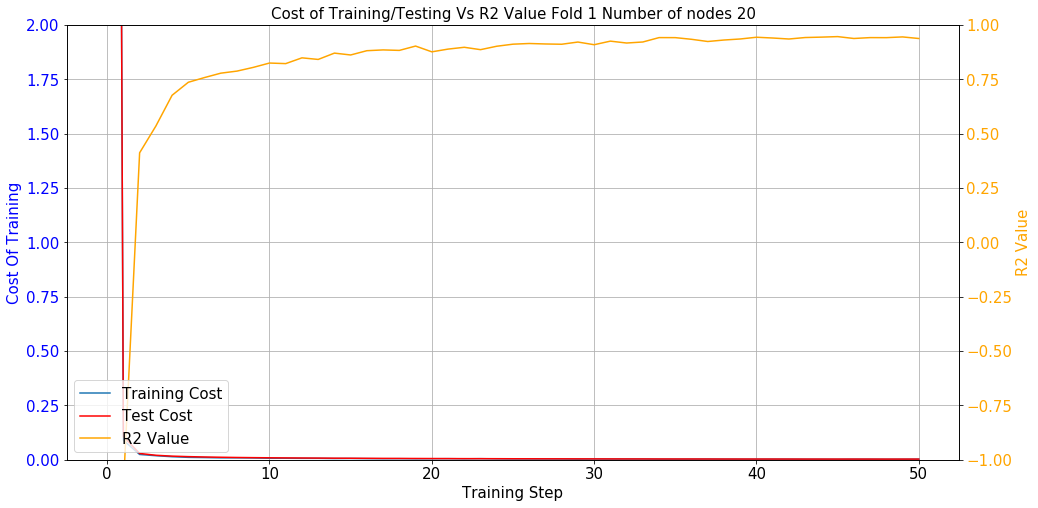

Working on Node 25 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpfbwg7c0q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40AED4B00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.009525743313133717
Cost_test : 0.010775596
R^2:0.7546342611312866
Epoch: 1200/5000 err = 0.008820253424346447
Cost_test : 0.009985613
R^2:0.7860522866249084
Epoch: 1300/5000 err = 0.0077637978829443455
Cost_test : 0.009339261
R^2:0.8018949031829834
Epoch: 1400/5000 err = 0.0077080088667571545
Cost_test : 0.008647772
R^2:0.8235477209091187
Epoch: 1500/5000 err = 0.006634202320128679
Cost_test : 0.0081806565
R^2:0.8321284055709839
Epoch: 1600/5000 err = 0.006459149997681379
Cost_test : 0.007758918
R^2:0.848444938659668
Epoch: 1700/5000 err = 0.0058496566489338875
Cost_test : 0.0072998344
R^2:0.863296627998352
Epoch: 1800/5000 err = 0.004987085238099098
Cost_test : 0.006929064
R^2:0.8773452043533325
Epoch: 1900/5000 err = 0.005291732028126717
Cost_test : 0.006540602
R^2:0.8755835890769958
Epoch: 2000/5000 err = 0.005340295843780041
Cost_test : 0.0062698275
R^2:0.8640376329421997
Epoch: 2100/5000 err = 0.005362120922654867
Cost_test : 0.005978734
R^2:0.884566605091

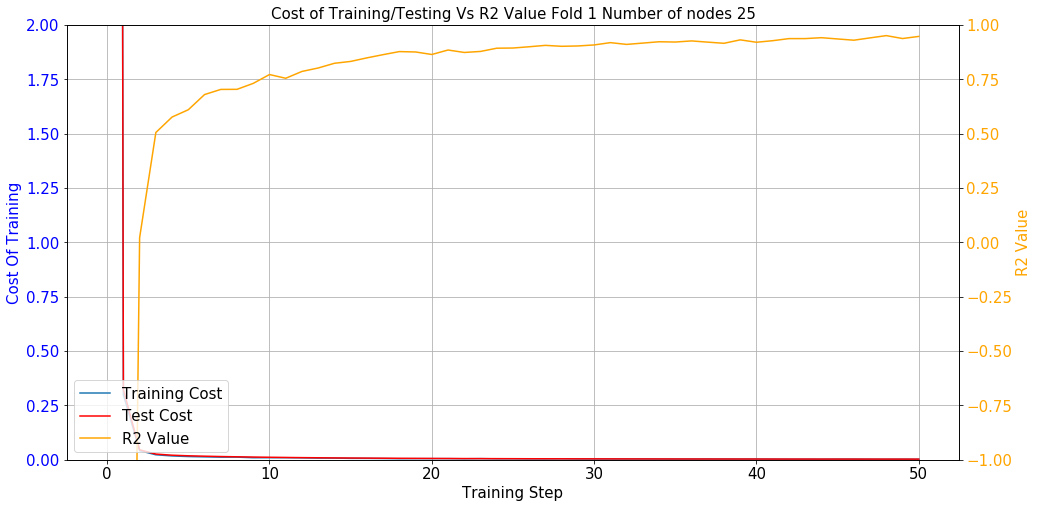

Working on Node 30 fold 1 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp37_j9gdd', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E401BA8390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

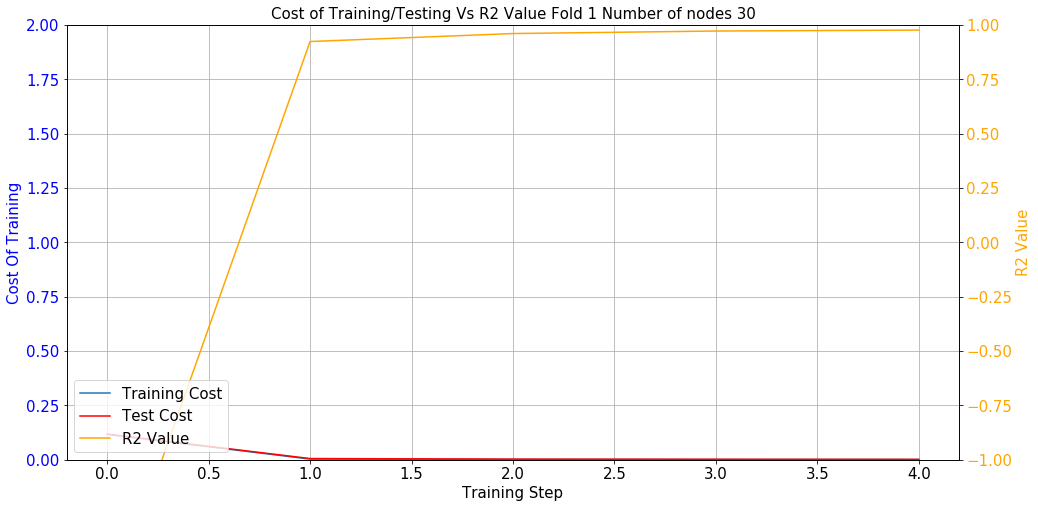

2
Working on Node 15 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp6ykel7o2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E401CEACF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.01668502576649189
Cost_test : 0.025156803
R^2:0.5698895454406738
Epoch: 1200/5000 err = 0.016923129558563232
Cost_test : 0.023941029
R^2:0.5502153038978577
Epoch: 1300/5000 err = 0.0159190371632576
Cost_test : 0.022841223
R^2:0.6015898585319519
Epoch: 1400/5000 err = 0.016095610335469246
Cost_test : 0.021783054
R^2:0.5587565302848816
Epoch: 1500/5000 err = 0.015968577936291695
Cost_test : 0.021213507
R^2:0.609360933303833
Epoch: 1600/5000 err = 0.014787634834647179
Cost_test : 0.020118903
R^2:0.6532361507415771
Epoch: 1700/5000 err = 0.014717387035489082
Cost_test : 0.019517919
R^2:0.643545389175415
Epoch: 1800/5000 err = 0.01463264413177967
Cost_test : 0.018726196
R^2:0.6543826460838318
Epoch: 1900/5000 err = 0.013414137996733189
Cost_test : 0.017920017
R^2:0.6643961668014526
Epoch: 2000/5000 err = 0.012970793060958385
Cost_test : 0.017487358
R^2:0.6481072306632996
Epoch: 2100/5000 err = 0.014019123278558254
Cost_test : 0.0168463
R^2:0.6413396596908569
Epoch: 

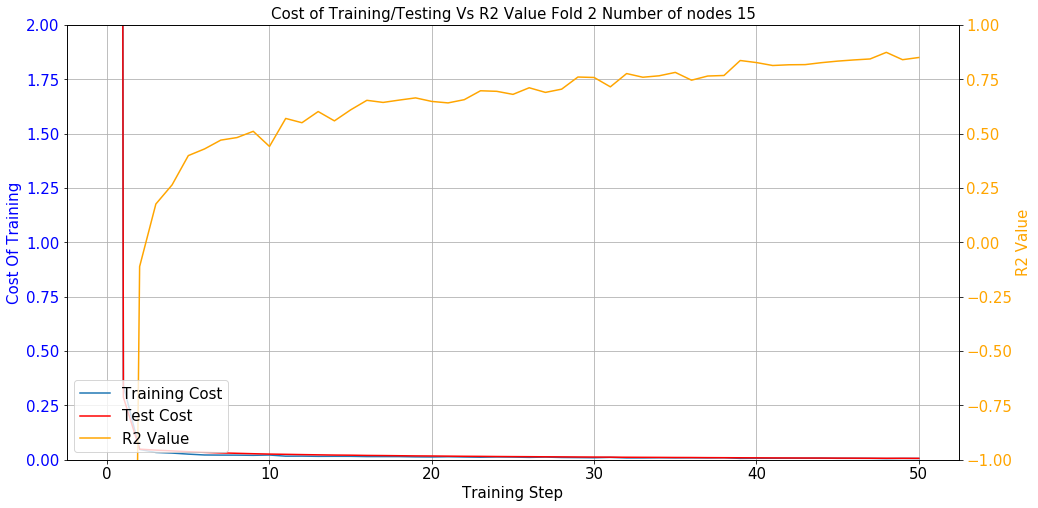

Working on Node 20 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpfxghk9kz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E3E803E278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.010033377446234226
Cost_test : 0.010916663
R^2:0.7639204859733582
Epoch: 1200/5000 err = 0.008479783311486244
Cost_test : 0.010140996
R^2:0.7725520133972168
Epoch: 1300/5000 err = 0.008698293939232826
Cost_test : 0.009385854
R^2:0.7694664597511292
Epoch: 1400/5000 err = 0.008022858761250973
Cost_test : 0.008682081
R^2:0.8267954587936401
Epoch: 1500/5000 err = 0.007473992183804512
Cost_test : 0.008054318
R^2:0.8266514539718628
Epoch: 1600/5000 err = 0.006516104098409414
Cost_test : 0.007519354
R^2:0.8433433175086975
Epoch: 1700/5000 err = 0.005708644632250071
Cost_test : 0.0070508984
R^2:0.8498908877372742
Epoch: 1800/5000 err = 0.005804018117487431
Cost_test : 0.006746008
R^2:0.8391036987304688
Epoch: 1900/5000 err = 0.006230667699128389
Cost_test : 0.0063515245
R^2:0.8678590655326843
Epoch: 2000/5000 err = 0.005209300201386213
Cost_test : 0.006059692
R^2:0.8710616230964661
Epoch: 2100/5000 err = 0.005031114909797907
Cost_test : 0.005762811
R^2:0.86848241090774

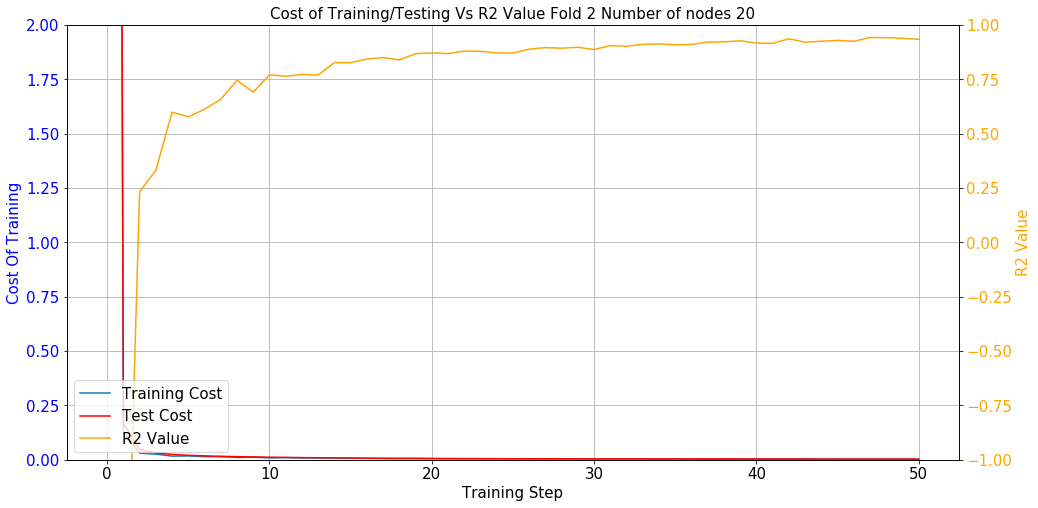

Working on Node 25 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpwhqaouhp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40C962630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.012147164903581142
Cost_test : 0.01830295
R^2:0.6905880570411682
Epoch: 1200/5000 err = 0.01122782751917839
Cost_test : 0.017056946
R^2:0.6998577117919922
Epoch: 1300/5000 err = 0.010044848546385765
Cost_test : 0.015975557
R^2:0.7405060529708862
Epoch: 1400/5000 err = 0.010700085200369358
Cost_test : 0.01495586
R^2:0.7308800220489502
Epoch: 1500/5000 err = 0.01029246486723423
Cost_test : 0.014196004
R^2:0.7741521000862122
Epoch: 1600/5000 err = 0.008652275428175926
Cost_test : 0.0132793775
R^2:0.7768110036849976
Epoch: 1700/5000 err = 0.009303206577897072
Cost_test : 0.012568808
R^2:0.7533164024353027
Epoch: 1800/5000 err = 0.008374433033168316
Cost_test : 0.011727824
R^2:0.806121826171875
Epoch: 1900/5000 err = 0.007728033233433962
Cost_test : 0.011313608
R^2:0.8050002455711365
Epoch: 2000/5000 err = 0.006956533994525671
Cost_test : 0.010535766
R^2:0.8232859373092651
Epoch: 2100/5000 err = 0.006797271315008402
Cost_test : 0.010006461
R^2:0.8062610626220703
Epo

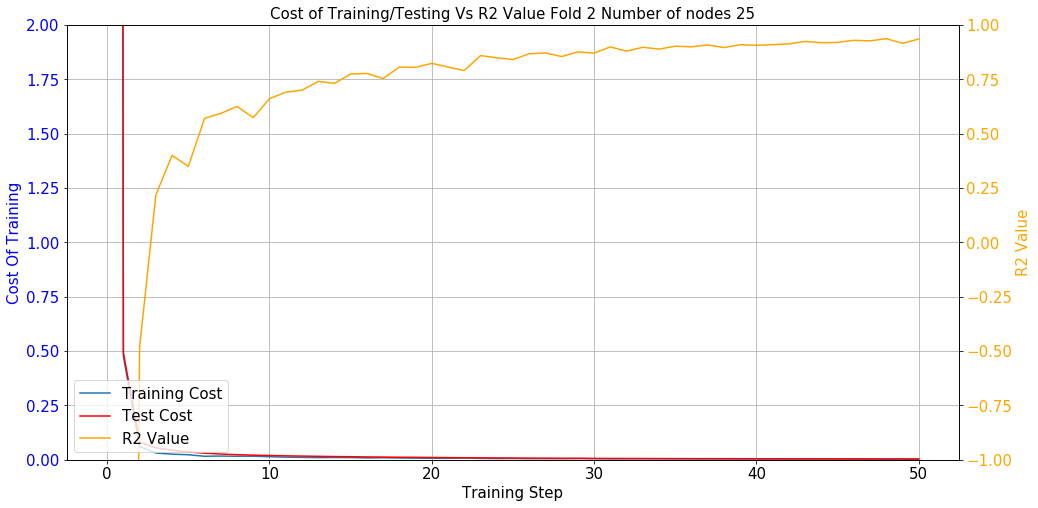

Working on Node 30 fold 2 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpdm2n3jwi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E401DA6CC0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

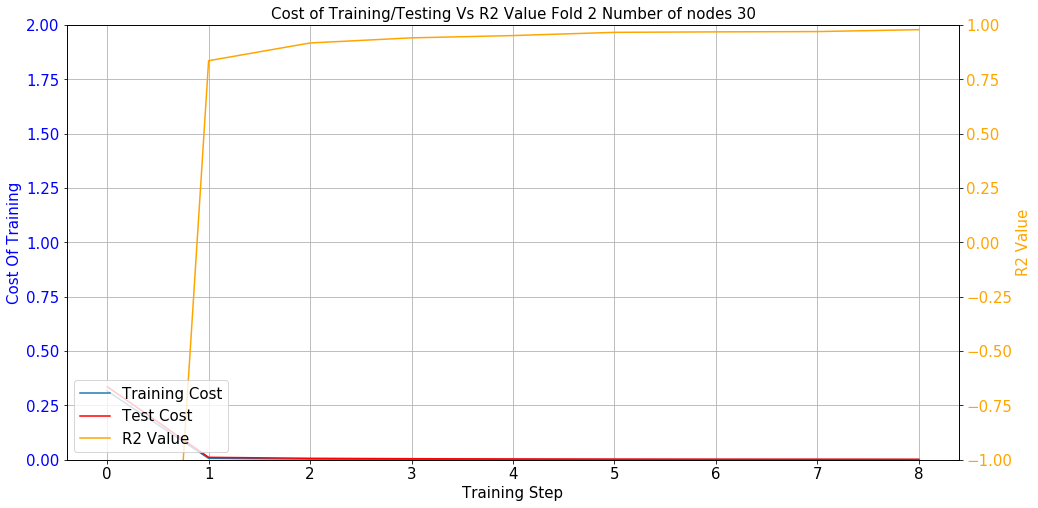

3
Working on Node 15 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpelw94xkh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40FED1E10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.015531477518379688
Cost_test : 0.016393758
R^2:0.6425914764404297
Epoch: 1200/5000 err = 0.01382854301482439
Cost_test : 0.015915152
R^2:0.6091940999031067
Epoch: 1300/5000 err = 0.01370339747518301
Cost_test : 0.015333234
R^2:0.6449754238128662
Epoch: 1400/5000 err = 0.013210084289312363
Cost_test : 0.014868905
R^2:0.6334754824638367
Epoch: 1500/5000 err = 0.010786380618810654
Cost_test : 0.01441324
R^2:0.7184829115867615
Epoch: 1600/5000 err = 0.011058551259338856
Cost_test : 0.014015229
R^2:0.720644474029541
Epoch: 1700/5000 err = 0.010425386019051075
Cost_test : 0.013524901
R^2:0.750133752822876
Epoch: 1800/5000 err = 0.011959443800151348
Cost_test : 0.013250968
R^2:0.7002095580101013
Epoch: 1900/5000 err = 0.009923337027430534
Cost_test : 0.01283762
R^2:0.7386404275894165
Epoch: 2000/5000 err = 0.011177248321473598
Cost_test : 0.012398788
R^2:0.710176944732666
Epoch: 2100/5000 err = 0.009511331096291542
Cost_test : 0.011976639
R^2:0.7697930932044983
Epoch:

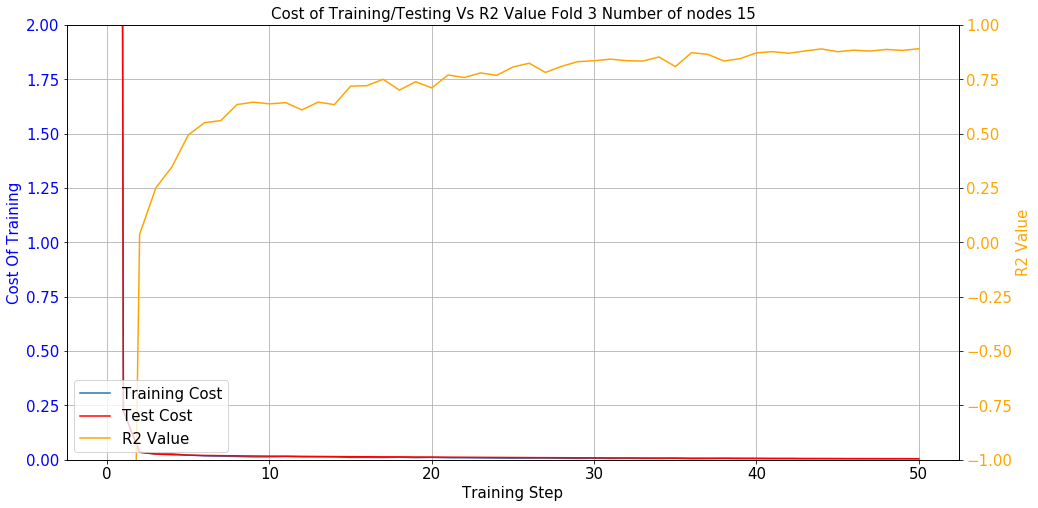

Working on Node 20 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpzg6coxd4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E401C775F8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.005704455077648163
Cost_test : 0.0067902342
R^2:0.8669335842132568
Epoch: 1200/5000 err = 0.004375392105430365
Cost_test : 0.006521617
R^2:0.8943453431129456
Epoch: 1300/5000 err = 0.0045744446106255054
Cost_test : 0.006159616
R^2:0.8835328817367554
Epoch: 1400/5000 err = 0.004181207157671452
Cost_test : 0.0059273015
R^2:0.8916027545928955
Epoch: 1500/5000 err = 0.004804578144103289
Cost_test : 0.005613335
R^2:0.8658045530319214
Epoch: 1600/5000 err = 0.004398559685796499
Cost_test : 0.0053830985
R^2:0.8847671747207642
Epoch: 1700/5000 err = 0.0034921278711408377
Cost_test : 0.0051469146
R^2:0.9025602340698242
Epoch: 1800/5000 err = 0.0035464006941765547
Cost_test : 0.004929831
R^2:0.9191877841949463
Epoch: 1900/5000 err = 0.004048504866659641
Cost_test : 0.0048114774
R^2:0.8950679302215576
Epoch: 2000/5000 err = 0.0032095382921397686
Cost_test : 0.004704405
R^2:0.9280881881713867
Epoch: 2100/5000 err = 0.003633562009781599
Cost_test : 0.0044976105
R^2:0.902757

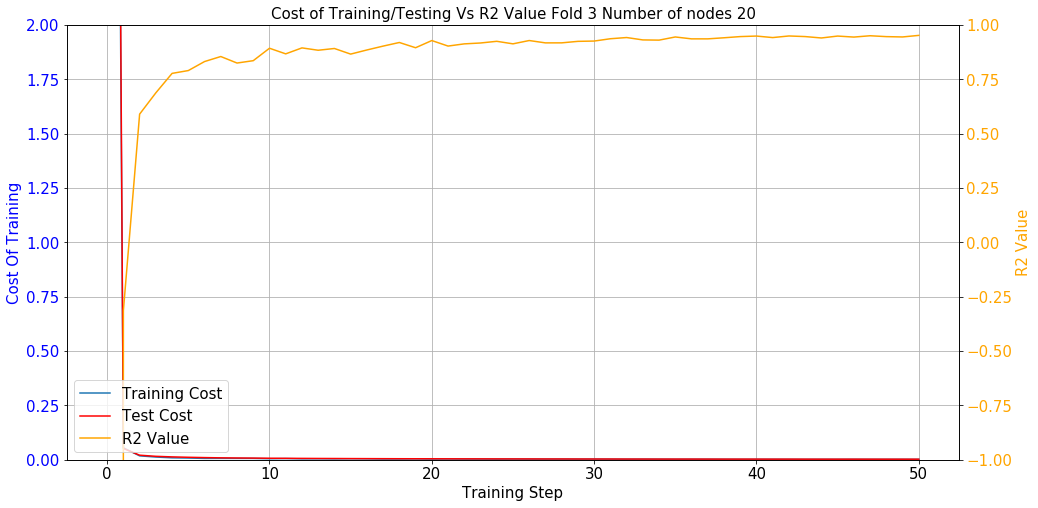

Working on Node 25 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmplm4gkgc3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40B084E10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.016253244131803513
Cost_test : 0.014237596
R^2:0.601665735244751
Epoch: 1200/5000 err = 0.013117597438395023
Cost_test : 0.013505609
R^2:0.6463024616241455
Epoch: 1300/5000 err = 0.012723926454782486
Cost_test : 0.0128086535
R^2:0.7089351415634155
Epoch: 1400/5000 err = 0.011247034184634686
Cost_test : 0.012165145
R^2:0.7203603982925415
Epoch: 1500/5000 err = 0.010648379102349281
Cost_test : 0.011566275
R^2:0.7667946219444275
Epoch: 1600/5000 err = 0.01042832713574171
Cost_test : 0.011061673
R^2:0.747393012046814
Epoch: 1700/5000 err = 0.010335599072277546
Cost_test : 0.010460119
R^2:0.7576112747192383
Epoch: 1800/5000 err = 0.01163986325263977
Cost_test : 0.0099999355
R^2:0.7303991317749023
Epoch: 1900/5000 err = 0.009553449228405952
Cost_test : 0.009502052
R^2:0.7757994532585144
Epoch: 2000/5000 err = 0.008932585828006268
Cost_test : 0.009103039
R^2:0.7499364018440247
Epoch: 2100/5000 err = 0.008770326152443886
Cost_test : 0.008679828
R^2:0.797015905380249
Ep

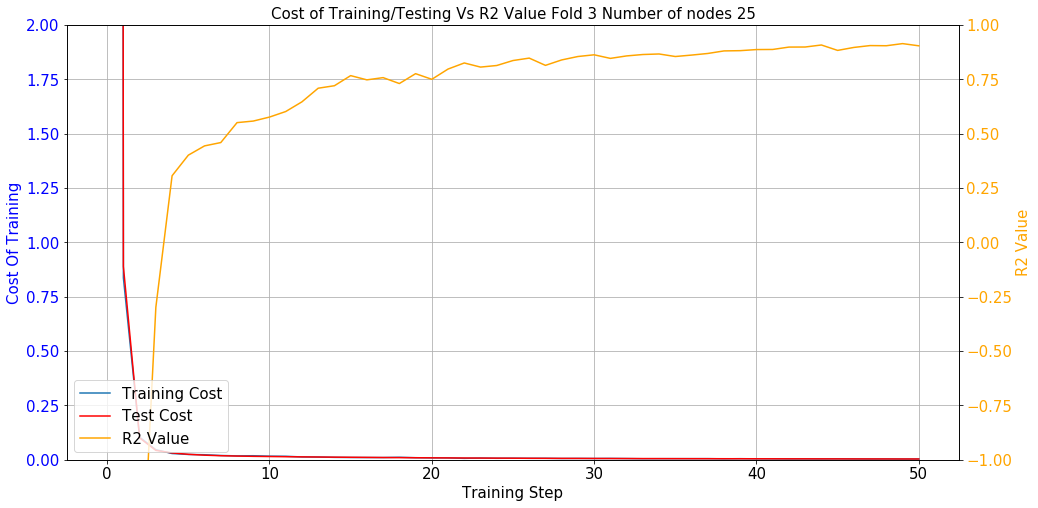

Working on Node 30 fold 3 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpdvvxy_hs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E401A18630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.000941047037485987
Cost_test : 0.0021314442
R^2:0.9779692888259888
End of learning process
Final epoch = 1120/5000 
Final error = 0.0007730677607469261
Final R^2 = 0.9813817143440247
[[1.50000000e+01 3.55329198e-01 8.37422789e-01 3.24742331e-01
  5.03940783e-01 9.78475043e-02 4.28909948e-03 8.83647740e+01]
 [2.00000000e+01 6.05320906e-01 8.31769805e-01 3.17100902e-01
  6.09074297e-01 1.01249767e-01 1.93054765e-03 1.08106770e+02]
 [2.50000000e+01 3.74502086e-01 8.44751430e-01 3.14893212e-01
  5.18433736e-01 9.34367431e-02 3.46178981e-03 1.27336366e+02]
 [3.00000000e+01 1.42030130e+00 3.40473923e-01 3.62602314e-01
  8.83487410e-01 3.96937432e-01 7.73067761e-04 5.95403280e+01]]


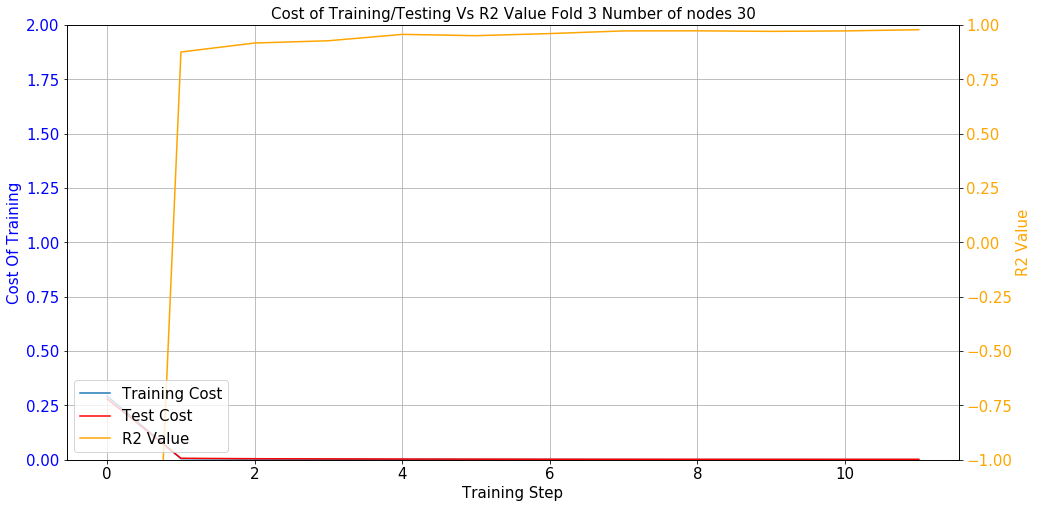

4
Working on Node 15 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpt_sdos78', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40A368B00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.018626486882567406
Cost_test : 0.019088741
R^2:0.559333324432373
Epoch: 1200/5000 err = 0.015829095616936684
Cost_test : 0.018291108
R^2:0.6632348299026489
Epoch: 1300/5000 err = 0.016681889072060585
Cost_test : 0.01773254
R^2:0.6192334294319153
Epoch: 1400/5000 err = 0.015507930889725685
Cost_test : 0.017134976
R^2:0.648577094078064
Epoch: 1500/5000 err = 0.015132403001189232
Cost_test : 0.016646687
R^2:0.6692081689834595
Epoch: 1600/5000 err = 0.014641765505075455
Cost_test : 0.016182927
R^2:0.6629930734634399
Epoch: 1700/5000 err = 0.01438102312386036
Cost_test : 0.015894795
R^2:0.6793308854103088
Epoch: 1800/5000 err = 0.01495753601193428
Cost_test : 0.015540321
R^2:0.6393316984176636
Epoch: 1900/5000 err = 0.012848613783717155
Cost_test : 0.015059201
R^2:0.688098669052124
Epoch: 2000/5000 err = 0.012862620875239372
Cost_test : 0.014666243
R^2:0.7194615602493286
Epoch: 2100/5000 err = 0.01235158834606409
Cost_test : 0.014210626
R^2:0.6876985430717468
Epoch:

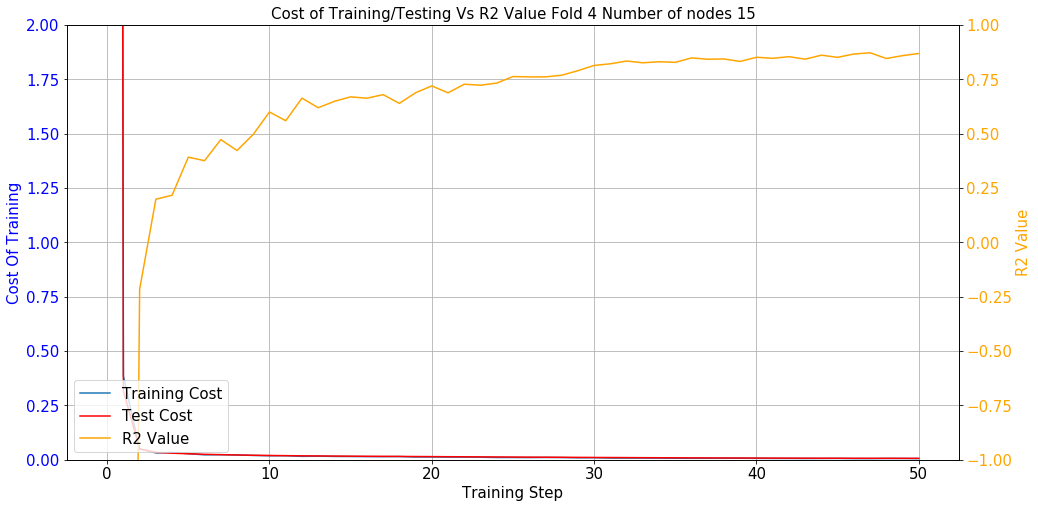

Working on Node 20 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpuruktal5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40A56AB38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.008796720765531063
Cost_test : 0.009914685
R^2:0.8095386028289795
Epoch: 1200/5000 err = 0.007567296270281076
Cost_test : 0.009431078
R^2:0.8399895429611206
Epoch: 1300/5000 err = 0.0077058314345777035
Cost_test : 0.008988803
R^2:0.8290050029754639
Epoch: 1400/5000 err = 0.007226583082228899
Cost_test : 0.008613044
R^2:0.8331944942474365
Epoch: 1500/5000 err = 0.005394278094172478
Cost_test : 0.00826281
R^2:0.8644639849662781
Epoch: 1600/5000 err = 0.006468372419476509
Cost_test : 0.007958566
R^2:0.8535438776016235
Epoch: 1700/5000 err = 0.006237313151359558
Cost_test : 0.007677963
R^2:0.8513493537902832
Epoch: 1800/5000 err = 0.005804562475532293
Cost_test : 0.0074053304
R^2:0.860725462436676
Epoch: 1900/5000 err = 0.00552601320669055
Cost_test : 0.00719467
R^2:0.8808196187019348
Epoch: 2000/5000 err = 0.0047980016097426414
Cost_test : 0.0069947243
R^2:0.8941078186035156
Epoch: 2100/5000 err = 0.004952882882207632
Cost_test : 0.0068930145
R^2:0.897790312767028

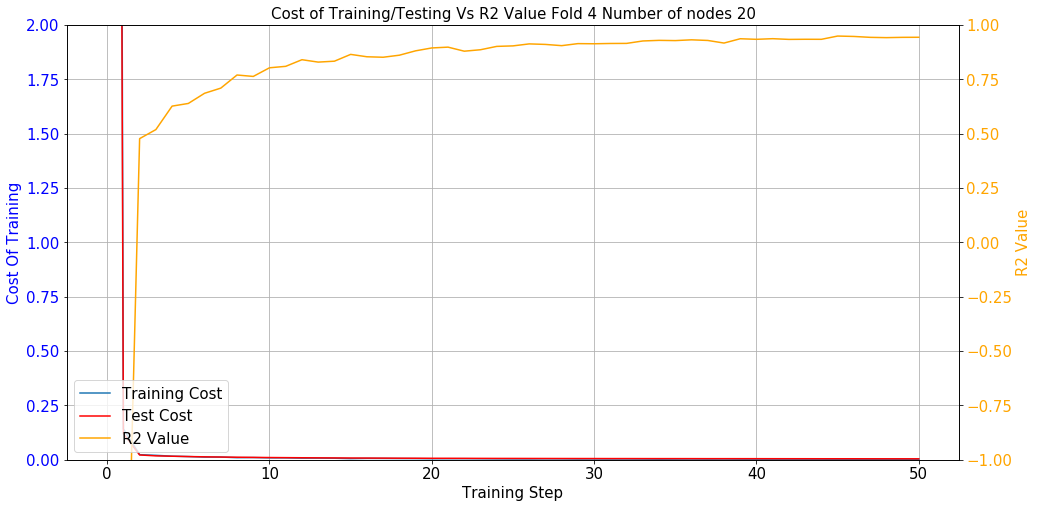

Working on Node 25 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmphnb6ptup', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40AD35208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.012427645735442638
Cost_test : 0.012644221
R^2:0.7162677049636841
Epoch: 1200/5000 err = 0.010874816216528416
Cost_test : 0.011693523
R^2:0.7176054120063782
Epoch: 1300/5000 err = 0.01140039972960949
Cost_test : 0.010812815
R^2:0.7312304973602295
Epoch: 1400/5000 err = 0.01055883802473545
Cost_test : 0.010186213
R^2:0.7606326341629028
Epoch: 1500/5000 err = 0.009022056125104427
Cost_test : 0.009638625
R^2:0.7875463366508484
Epoch: 1600/5000 err = 0.007982232607901096
Cost_test : 0.009171126
R^2:0.8185745477676392
Epoch: 1700/5000 err = 0.008053026162087917
Cost_test : 0.008778784
R^2:0.8065053820610046
Epoch: 1800/5000 err = 0.008454189635813236
Cost_test : 0.008387605
R^2:0.8137825727462769
Epoch: 1900/5000 err = 0.00664959941059351
Cost_test : 0.008087239
R^2:0.8577554225921631
Epoch: 2000/5000 err = 0.0063511342741549015
Cost_test : 0.007837069
R^2:0.8704060316085815
Epoch: 2100/5000 err = 0.00670048501342535
Cost_test : 0.007584385
R^2:0.8370277881622314
Ep

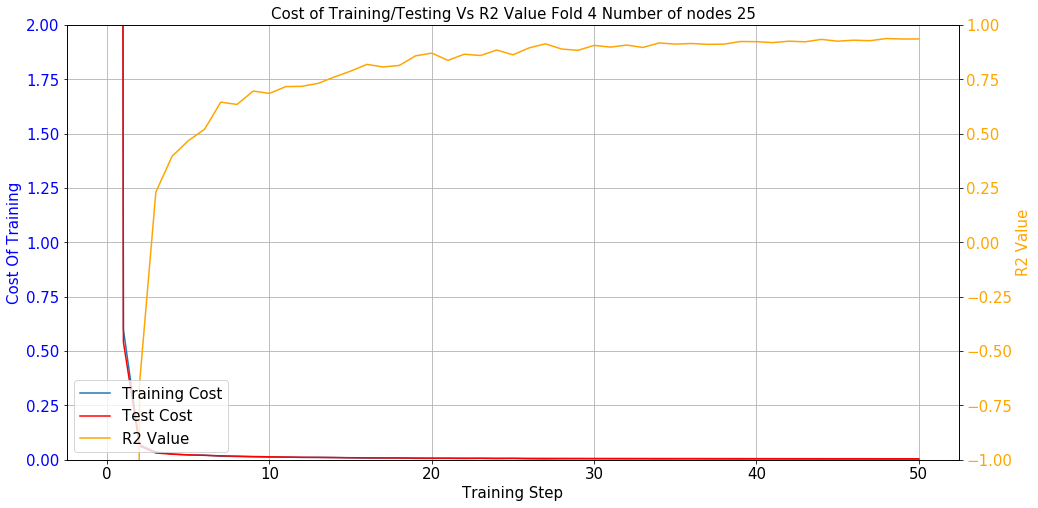

Working on Node 30 fold 4 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpoypp1kq3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40A389CC0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

[[1.50000000e+01 3.20013015e-01 7.91278998e-01 3.36104905e-01
  5.28461187e-01 1.25619262e-01 5.44541096e-03 9.06109822e+01]
 [2.00000000e+01 4.97006695e-01 8.40460091e-01 3.17155080e-01
  5.89483095e-01 9.60194968e-02 2.56389845e-03 1.30001688e+02]
 [2.50000000e+01 4.26585426e-01 8.43570512e-01 3.07389615e-01
  5.86787792e-01 9.41474819e-02 2.82931444e-03 2.95968134e+02]
 [3.00000000e+01 1.50345727e+00 5.63007929e-01 3.55435774e-01
  7.45008393e-01 2.63004780e-01 9.80773475e-04 6.46876154e+01]]


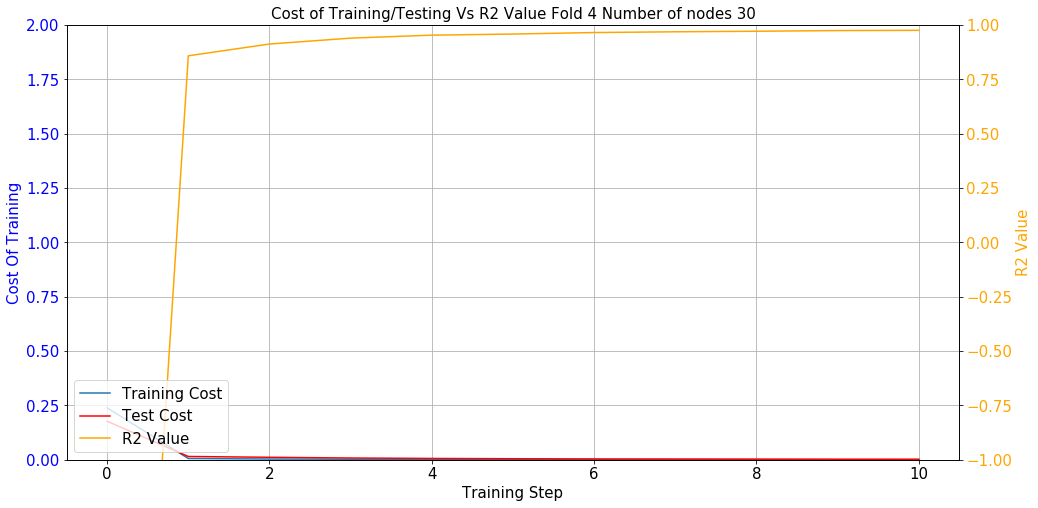

5
Working on Node 15 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp34_no7kj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E401B53748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

Epoch: 1100/5000 err = 0.01602320186793804
Cost_test : 0.01671104
R^2:0.6222069263458252
Epoch: 1200/5000 err = 0.013560937717556953
Cost_test : 0.015813792
R^2:0.672841489315033
Epoch: 1300/5000 err = 0.012961403466761112
Cost_test : 0.014836162
R^2:0.63871169090271
Epoch: 1400/5000 err = 0.012382851913571358
Cost_test : 0.014205282
R^2:0.70376056432724
Epoch: 1500/5000 err = 0.01334970723837614
Cost_test : 0.013521586
R^2:0.6519456505775452
Epoch: 1600/5000 err = 0.01421009935438633
Cost_test : 0.012755041
R^2:0.6523653864860535
Epoch: 1700/5000 err = 0.010731445625424385
Cost_test : 0.012280631
R^2:0.7429146766662598
Epoch: 1800/5000 err = 0.010889912955462933
Cost_test : 0.011690943
R^2:0.7094776630401611
Epoch: 1900/5000 err = 0.01133264321833849
Cost_test : 0.011292249
R^2:0.7112935185432434
Epoch: 2000/5000 err = 0.009230250492691994
Cost_test : 0.010807097
R^2:0.7678983807563782
Epoch: 2100/5000 err = 0.00883482489734888
Cost_test : 0.010358155
R^2:0.7750945687294006
Epoch: 220

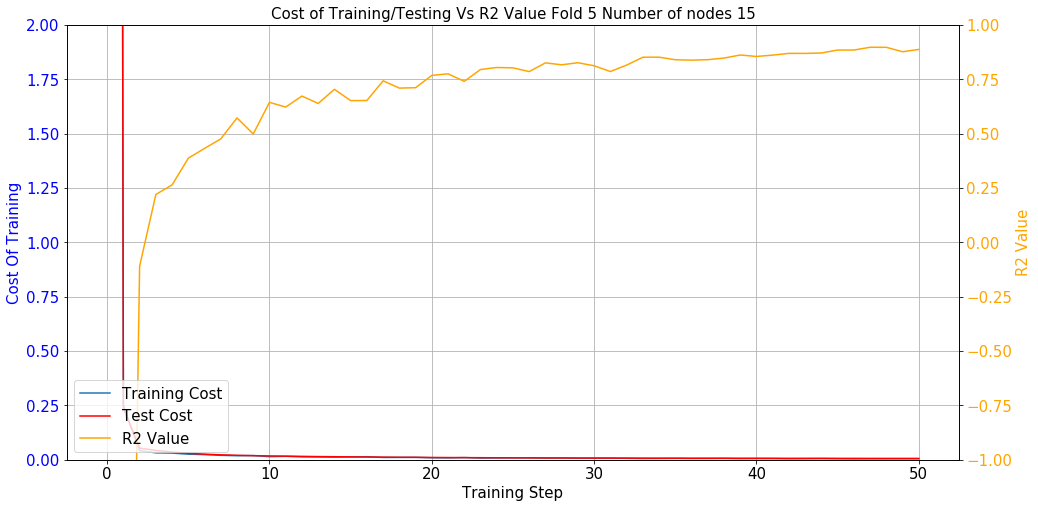

Working on Node 20 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpepdmtvnz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E401B89940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.010296355001628399
Cost_test : 0.010502466
R^2:0.7783491015434265
Epoch: 1200/5000 err = 0.008832753635942936
Cost_test : 0.009743518
R^2:0.7831814289093018
Epoch: 1300/5000 err = 0.007652702741324902
Cost_test : 0.009212543
R^2:0.7873609066009521
Epoch: 1400/5000 err = 0.007680428680032492
Cost_test : 0.0087563535
R^2:0.8305003046989441
Epoch: 1500/5000 err = 0.007206023670732975
Cost_test : 0.00831594
R^2:0.8304928541183472
Epoch: 1600/5000 err = 0.006518386770039797
Cost_test : 0.007962296
R^2:0.8403394222259521
Epoch: 1700/5000 err = 0.006795196328312159
Cost_test : 0.007591793
R^2:0.8248718976974487
Epoch: 1800/5000 err = 0.005947763100266457
Cost_test : 0.007276409
R^2:0.839653491973877
Epoch: 1900/5000 err = 0.006288350559771061
Cost_test : 0.007280753
R^2:0.8438759446144104
Epoch: 2000/5000 err = 0.005590190179646015
Cost_test : 0.006900364
R^2:0.8780636787414551
Epoch: 2100/5000 err = 0.005413883365690708
Cost_test : 0.0066729337
R^2:0.853898823261261


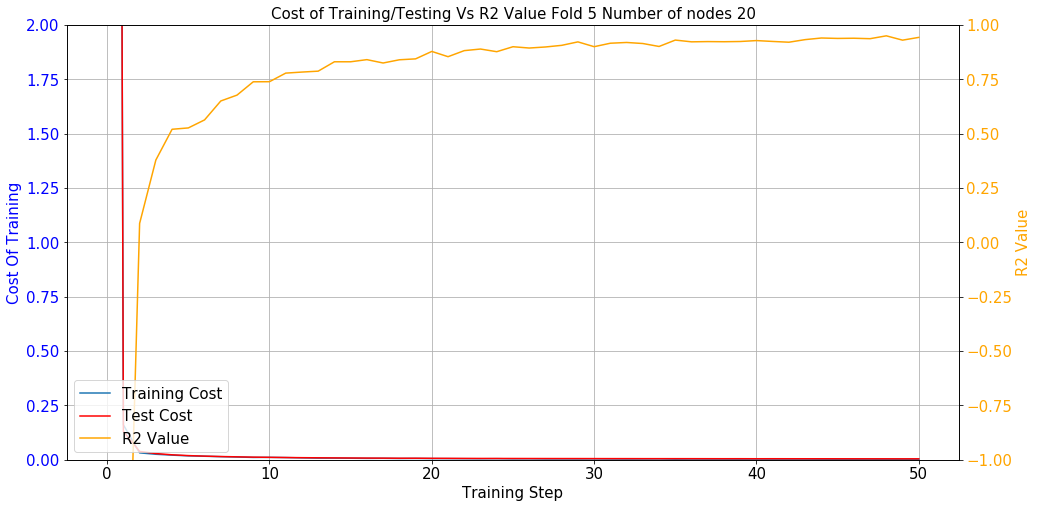

Working on Node 25 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmp78v6mjzx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E40AF39A20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

Epoch: 1100/5000 err = 0.017828060314059258
Cost_test : 0.017406572
R^2:0.5738232135772705
Epoch: 1200/5000 err = 0.014129573479294777
Cost_test : 0.016203592
R^2:0.6887197494506836
Epoch: 1300/5000 err = 0.014317428693175316
Cost_test : 0.015058903
R^2:0.6514103412628174
Epoch: 1400/5000 err = 0.01258507464081049
Cost_test : 0.0140423905
R^2:0.6600186824798584
Epoch: 1500/5000 err = 0.011667533777654171
Cost_test : 0.013075266
R^2:0.7127468585968018
Epoch: 1600/5000 err = 0.010432115755975246
Cost_test : 0.012326027
R^2:0.7478352785110474
Epoch: 1700/5000 err = 0.010032588616013527
Cost_test : 0.0114898
R^2:0.7543932199478149
Epoch: 1800/5000 err = 0.009354113601148129
Cost_test : 0.0107768085
R^2:0.7438554763793945
Epoch: 1900/5000 err = 0.009387626312673092
Cost_test : 0.01014879
R^2:0.7643387317657471
Epoch: 2000/5000 err = 0.008835392072796822
Cost_test : 0.009611743
R^2:0.7777957320213318
Epoch: 2100/5000 err = 0.00789937749505043
Cost_test : 0.009133567
R^2:0.8089685440063477
Ep

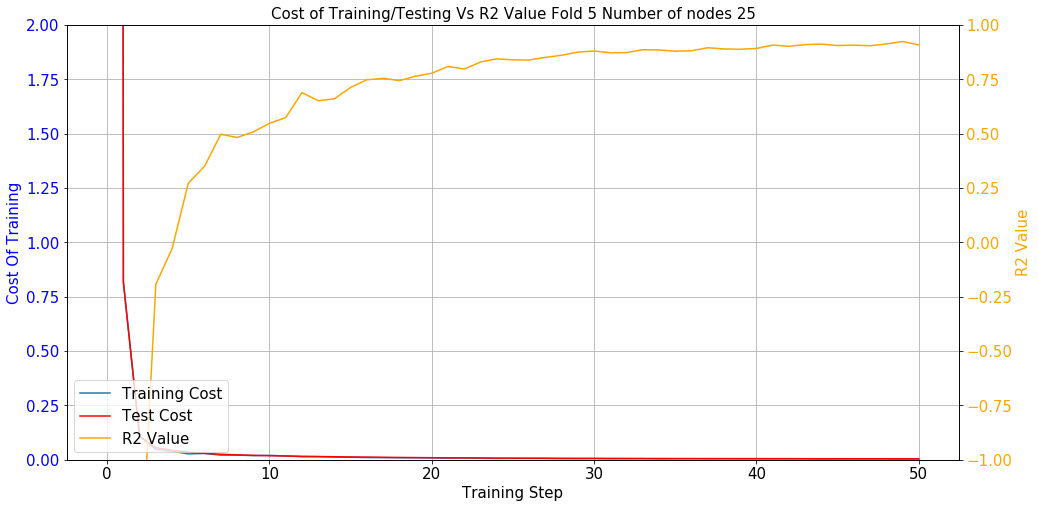

Working on Node 30 fold 5 
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Matt\\AppData\\Local\\Temp\\tmpn3lrgrsx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E4005F0D68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

End of learning process
Final epoch = 1009/5000 
Final error = 0.0009430838981643319
Final R^2 = 0.980302631855011
[[1.50000000e+01 3.39889320e-01 8.23776973e-01 3.20547436e-01
  5.38127013e-01 1.06060273e-01 4.73086676e-03 9.92225294e+01]
 [2.00000000e+01 4.99512537e-01 8.63906856e-01 3.25577443e-01
  5.91472844e-01 8.19080022e-02 2.56969826e-03 1.38056826e+02]
 [2.50000000e+01 3.76322920e-01 8.20722679e-01 3.04647660e-01
  5.48190719e-01 1.07898508e-01 3.49311437e-03 2.38577982e+02]
 [3.00000000e+01 1.33137726e+00 6.05978607e-01 3.54124525e-01
  7.42694852e-01 2.37142769e-01 9.43083898e-04 6.42992167e+01]]


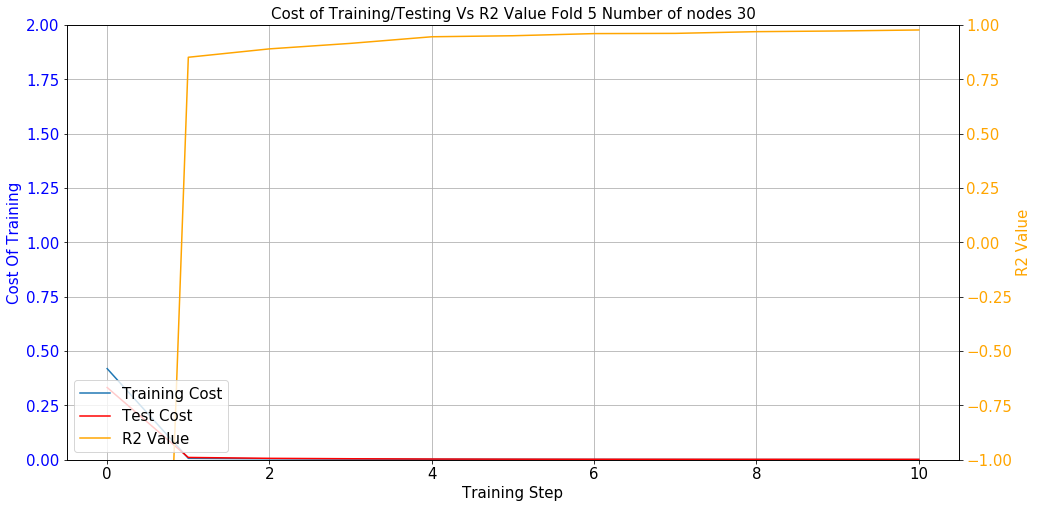

In [24]:
from sklearn.model_selection import KFold
#Prediction Grid
x,y,z = griddef.gridcoord()
#DH Sample Data
datatest = np.asarray(datasamplefl)
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])
print(min_val)
print(max_val)
datatest[:,3] = (datatest[:,3]-min_val)/(max_val-min_val)
data_x = np.hstack((x.reshape(len(x),1),y.reshape(len(y),1),z.reshape(len(z),1)))/100
kf = KFold(n_splits = 5, shuffle=True)
kf.get_n_splits(datatest)
fold_num= 0
columns = ['X','Y','Z','value']
n_batch = 1
RFB_type = 'Gaussian'
for train_index, test_index in kf.split(datatest):
    fold_num += 1
    print(fold_num)
    #print("TRAIN:", train_index, "TEST:", test_index)
    data_train, data_test = datatest[train_index,0:3]/100, datatest[test_index,0:3]/100
    target_train, target_test = datatest[train_index,3:4], datatest[test_index,3:4]
    gs.write_gslib(pd.DataFrame(np.hstack((data_train*100,target_train*(max_val-min_val)+min_val)),columns=columns), './data/data_train_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(np.hstack((data_test*100,target_test*(max_val-min_val)+min_val)),columns=columns), './data/data_test_{}.dat'.format(fold_num))
    row = 0
    NN = 'RBFN' # RBFN or GRNN or 'EBFN'
    data_type = 'Continuous' # Continuous or Categorical
    test_nodes = [15,20,25,30]
    pred_all = np.zeros((len(test_nodes)*data_x.shape[0],target_train.shape[1]))
    pred_all_row = np.zeros((data_x.shape[0],target_train.shape[1],len(test_nodes)))
    info_matrix = np.zeros((len(test_nodes),8))
    for nodes in test_nodes:
        c_t = []
        c_test = []
        c_r2 = []
        start_time = time.time()
        print("Working on Node {} fold {} ".format(nodes,fold_num))
        k = nodes
        data_trainpd = pd.DataFrame(data_train)
        data = data_trainpd

        with tf.device('/device:CPU:0'):
            #clustering
            def input_fn():
              return tf.train.limit_epochs(
                  tf.convert_to_tensor(data_train, dtype=tf.float32), num_epochs=1)

            kmeans = tf.contrib.factorization.KMeansClustering(
                num_clusters=nodes, use_mini_batch=False)


            # train
            num_iterations = 10
            previous_centers = None
            for _ in range(num_iterations):
              kmeans.train(input_fn)
              cluster_centers = kmeans.cluster_centers()
              #if previous_centers is not None:
                #print('delta:', cluster_centers - previous_centers)
              previous_centers = cluster_centers
              #print('score:', kmeans.score(input_fn))
            #print('cluster centers:', cluster_centers)
            
            
        with tf.device('/device:GPU:0'):
            from tensorflow.python.framework import ops
            ops.reset_default_graph()


            RANDOM_SEED = 42
            tf.set_random_seed(RANDOM_SEED)

            N_INSTANCES = np.shape(data_train)[0]
            N_INPUT = data_train.shape[0]
            N_FEATURE = data_train.shape[1]
            N_CLASSES = target_train.shape[1]
            TRAIN_SIZE = int(N_INSTANCES)
            batch_size = int(np.shape(data_train)[0]/n_batch)
            training_epochs = 5000
            if nodes >= 2:
                training_epochs = 5000
            if nodes >= 25:
                training_epochs = 5000
            if nodes >= 100:
                training_epochs = 5000
            if nodes >= 1000:
                training_epochs = 5000
            learning_rate = 0.01
            epsilon = 0.001
            display_step = 100
            hidden_size = nodes

            target_ = np.zeros((N_INSTANCES, N_CLASSES))
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            x_data = tf.placeholder(shape=[None, N_FEATURE], dtype=tf.float32, name = 'Features')
            y_target = tf.placeholder(shape=[None, N_CLASSES], dtype=tf.float32, name = 'Known_Values')


            dist = np.zeros((k,k))
            for i in range (0,k):
                for j in range (0,k):
                    dist[i:j] = distance.euclidean(cluster_centers[i], cluster_centers[j])
                    maxdist = dist.max()
            sigma = maxdist/np.sqrt(2*k)
            if nodes == 1 :
                beta = 0.2
            else:        
                beta = 1/math.pow(2*sigma,2)

            #EBFN
            if NN == 'RBFN':
                def rbf_network(input_layer, cluster_centers ,weights):
                    
                    exp_list= []
                    with tf.name_scope('Input_Layer'):
                        input_layer
                    #yy = tf.convert_to_tensor(np.asarray(cluster_centers).reshape(nodes,N_FEATURE), dtype=tf.float32)
                    with tf.name_scope('Cluster_Centers'):
                        yy = weights['cluster_centers']

                    for i in range(nodes):
                        with tf.name_scope('Euclidean_Dist'):
                            cc_i = yy[i]
                            euclidean_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(input_layer, cc_i)), 1))

                        
                        with tf.name_scope('Gaussian_Activation_Layer'):
                            gauss_f = tf.math.exp((-tf.math.pow((weights['beta'][:,i]*euclidean_dist), 2)))
                        

                            exp_list.append(gauss_f)
                    with tf.name_scope('Output_Layer'):        
                        layer2_act = tf.stack(exp_list)   
                        output = tf.add(tf.matmul(layer2_act, weights['output'],transpose_a=True,name = 'mult_layer2_by_weights'), bias['output'], 
                                    name = 'add_bias_to_output')     
                    return output

            weights = {
                'h1': tf.Variable(tf.ones([N_FEATURE, N_FEATURE,nodes]), name = 'layer1_dims'),
                'output': tf.Variable(tf.ones([nodes, N_CLASSES]), name = 'layer2_output_Weights'),
                'cov_mat': tf.Variable(tf.ones(shape = [N_FEATURE,N_FEATURE,nodes]), name = 'cov'),
                'beta' : tf.Variable(tf.constant(beta,shape = [1,nodes]) ,name = 'r'),            
                'cluster_centers' : tf.Variable(tf.constant(np.asarray(cluster_centers).reshape(nodes,N_FEATURE),
                                    shape = [nodes,N_FEATURE]), name = 'cluster_center')
            }

            bias = {
                'output' : tf.Variable([0],name='output_bias',dtype=tf.float32)  
            }


            pred = rbf_network(x_data, cluster_centers ,weights)

            if data_type == 'Continuous':
                with tf.name_scope('cost'):
                    cost = tf.reduce_mean(tf.square(pred - y_target))
                    #cost = tf.math.reduce_sum(tf.square(pred - y_target)) 
                    my_opt = tf.train.AdamOptimizer(learning_rate,beta1=0.5).minimize(cost)  
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    total_error = tf.reduce_sum(tf.square(tf.subtract(y_target, tf.reduce_mean(y_target))))
                    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_target, pred)))
                    accuracy = tf.subtract(1.00, tf.divide(unexplained_error, total_error))

            if data_type == 'Categorical':
                with tf.name_scope('cost'):
                    if N_CLASSES == 1:
                        cost = tf.reduce_mean(tf.square(tf.round(pred) - y_target)) 
                    else:
                        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = pred))
                    my_opt = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
                    tf.summary.scalar('cost', cost)

                with tf.name_scope('accuracy'):
                    correct_prediction = tf.equal(tf.round(pred), y_target)
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


#             tf.summary.histogram("cov_mat", weights['cov_mat'])
#             tf.summary.histogram("Weights_Output_Layer", weights['output'])
#             tf.summary.histogram("Bias_Output_Layer", bias['output'])




            init = tf.global_variables_initializer()
            sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
            merged = tf.summary.merge_all()
            saver = tf.train.Saver()
            writer = tf.summary.FileWriter('./test',sess.graph)
            sess.run(init)
            tol = 0.00001
            epoch, err, acc=0, 1, 0
            # Training loop
            #saver.restore(sess,'./spatial/test_dataset_{}.ckpt'.format(nodes))
            while epoch <= training_epochs and err >= tol and acc <= 0.98:

                avg_cost = 0.
                acc = 0.
                total_batch = int(data_train.shape[0] / batch_size)
                for i in range(total_batch):
                    randidx = np.random.randint(int(TRAIN_SIZE), size=batch_size)
                    batch_xs = data_train[randidx , :]
                    batch_ys = target_train[randidx , :]
                    sess.run(my_opt, feed_dict={x_data: batch_xs, y_target: batch_ys})
                    avg_cost += sess.run(cost, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                    acc += sess.run(accuracy, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
                err = avg_cost
                if epoch % 100 == 0:
                    #summary = sess.run([merged],feed_dict={x_data: batch_xs, y_target: batch_ys})
                    #writer.add_summary(summary,epoch)
                    print("Epoch: {}/{} err = {}".format(epoch, training_epochs, avg_cost))
                    print('Cost_test :',sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_t.append(avg_cost)
                    c_test.append(sess.run(cost, feed_dict={x_data:data_test,y_target:target_test}))
                    c_r2.append(acc)
                    if data_type == 'Categorical': 
                        print("Accuracy:{}".format(acc))
                    else:
                        print("R^2:{}".format(acc))    

                epoch +=1

            print ("End of learning process")
            print ("Final epoch = {}/{} ".format(epoch, training_epochs))
            print ("Final error = {}".format(err) )
            print ("Final R^2 = {}".format(acc) )
            saver.save(sess,'./spatial/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            w = np.vsplit(data_x,500)[0].shape[0]
            pred1 = np.zeros((data_x.shape[0],N_CLASSES))
            for i in range(0,500):
                pred1[i*w:(1+i)*w,0:N_CLASSES] = (sess.run(pred, feed_dict={x_data:np.vsplit(data_x,500)[i]}))*(max_val-min_val)+min_val
                pred_all[i*w+(row*data_x.shape[0]):(1+i)*w+(row*data_x.shape[0]),0:N_CLASSES] = pred1[i*w:(1+i)*w,0:N_CLASSES]
                pred_all_row[i*w:(1+i)*w,0:N_CLASSES,row] = pred1[i*w:(1+i)*w,0:N_CLASSES]

            writer = tf.summary.FileWriter("sess_graph", sess.graph)
            saver.save(sess,'test/test_dataset_{}_{}.ckpt'.format(nodes,fold_num))
            sess.close() 

            gs.write_gslib(pd.DataFrame(pred1), './predictions/real_{}_{}.dat'.format(nodes,fold_num))

            info_matrix[row,0] = k
            info_matrix[row,1] = beta
            info_matrix[row,2] = r2_score(sgsimfl['value'],pred1)
            info_matrix[row,3] = np.mean(pred1)
            info_matrix[row,4] = np.var(pred1)
            info_matrix[row,5] = mean_squared_error(sgsimfl['value'],pred1)
            info_matrix[row,6] = err
            info_matrix[row,7] = (time.time() - start_time) 
            row +=1
            tf.InteractiveSession.close(sess)
        print(info_matrix)
        SMALL_SIZE = 15
        plt.rc('font', size=SMALL_SIZE)
        plt.rc('axes', titlesize=SMALL_SIZE)
        f, (ax1) = plt.subplots(1, 1,figsize=(16, 8))
        ax1.set_ylim([0,2])
        ax1.plot(range(len(c_t)), c_t, label ='Training Cost')
        ax1.plot(range(len(c_t)), c_test, color="red",label ='Test Cost')
        ax1.set_xlabel('Training Step')
        ax1.grid(True)
        ax1.set_title('Cost of Training/Testing Vs R2 Value Fold {} Number of nodes {}'.format(fold_num,nodes))
        ax1.set_ylabel('Cost Of Training', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2 = ax1.twinx()
        ax2.plot(range(len(c_t)), c_r2,'-',color="orange",label ='R2 Value')
        ax2.set_ylim([-1,1])
        ax2.set_ylabel('R2 Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=3)
        plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Training_R2_01_{}_{}.png'.format(nodes,fold_num))
        plt.show()


    ensemble = numpy.nanmean(pred_all_row, axis = 2)
    gs.write_gslib(pd.DataFrame(ensemble), './predictions/ensemble_{}.dat'.format(fold_num))
    gs.write_gslib(pd.DataFrame(pred_all), './predictions/all_real_{}.dat'.format(fold_num))

In [6]:
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
3                                 -number of directions
135 22.5 200 0.0 22.5 200 0.0   -Dir 01: azm,azmtol,bandhorz,dip,dipt
 20  100  50                 -        number of lags,lag distanc
45 22.5 200 0.0 22.5 200 0.0   -Dir 02: azm,azmtol,bandhorz,dip,dipt
 20  100  50                 -        number of lags,lag distanc
0. 22.5 200 90.0 22.5 200 0.0   -Dir 03: azm,azmtol,bandhorz,dip,
 20  5.0  2.5                 -        number of lags,lag distanc
./vargs/varcalc_{fold}.out                       -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill



NOTES ON VARIOGRAM CALCULATION:
1) By default, varcalc runs checks for common errors in parameter choices. This can be
   disabled if desired. 
2) Varcalc can standardize using a provided sill (such as a declustered variance).
   For example, if variable 1 has a declustered variance of 8.6, the traditional
   semivariogram could be standardized by setting the variogram type to:
      1  1  1  8.6
   Alternatively, varcalc can attempt to infer a sill for standardizing by setting
   the variogram type to:
      1  1  1  ?
   The calculated sills will be written to the console. 
3) Variogram types are the same as in GSLIB:
      1 = traditional semivariogram
      2 = traditional cross semivariogram
      3 = covariance   (-3 calculates variance (provided sill) -covariance)
      4 = correlogram  (-4 calculates 1-correlation)
      5 = general relative semivariogram
      6 = pairwise relative semivariogram
      7 = semivariogram of logarithms
      8 = semimadogram
      9 = indicator semivariogram - continuous  - requires a cutoff
      10= indicator semivariogram - categorical - requires a category
4) For indicator variograms, the variogram cutoff/categories are specified immediately after the variogram type
    1   1   9   1.0   ?               -tail variable, head variable, variogram type (and cutoff/category), sill
5) If desired, the program can write out the variogram points in the gamv2004 style
   for compatibility with older versions. Tilt was not supported in pre-varcalc experimental variogram
   programs so use carefully. 
"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
3                            -number of directions to model points along
  135   0.0  1000   0.5      -  azm, dip, npoints, point separation
  45    0.0  1000   0.5      -  azm, dip, npoints, point separation
    0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
2    0.01                   -nst, nugget effect
3    0:0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        100:300     100:300     50:500    -a_hmax, a_hmin, a_vert (ranges)
3    0:0.99    135   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        100:300     100:300     50:500    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}             -file with data
0  {xyzcol} {varcol}  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out                        -file for kriged output (see GSB note)
{griddef}
1    1      1                    -x,y and z block discretization
25    50    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
500.0  500.0  250.0              -maximum search radii
135.0  0.0   0.0                 -angles for search ellipsoid
0                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.367 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varg}
"""

In [9]:
varcalc = gs.Program('varcalc')
varmodel = gs.Program('varmodel')
kt3dn = gs.Program('kt3dn')
for fold in range(1,6):
    Traindat = gs.DataFile('./data/data_train_{}.dat'.format(fold))

    

    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
    kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('value'),
                             griddef = griddef,
                             varg = varg,
                             fold = fold))

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_1.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            3
  direction parameters:
 azm,azmtol,bandhorz   135.000000000000        22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   100.000000000000     
   50.0000000000000     
 azm,azmtol,bandhorz   45.0000000000000        22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   100.000000000000     
   50.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.500000000

Calling:  ['varmodel', 'temp']

varmodel version: 1.1.1

  output points file: ./vargs/varmodel_2.out
  number of directions to model points along:            3
  azm, dip, npoints, pointsep:    135.000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:    45.0000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        1000  0.500000000000000     
  nst =           2
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            1      100000
  number of variogram files:            1
  variogram file: ./vargs/varcalc_2.out
  using variograms            1           2           3
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output fil

   currently on estimate      6250
   currently on estimate     12500
   currently on estimate     18750
   currently on estimate     25000
   currently on estimate     31250
   currently on estimate     37500
   currently on estimate     43750
   currently on estimate     50000
   currently on estimate     56250
   currently on estimate     62500

 KT3DN Version:    7.100 Finished

Calling:  ['varcalc', 'temp']

varcalc version:  1.400

  data file: ./data/data_train_4.dat
  x,y,z columns:            1           2           3
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            3
  direction parameters:
 azm,azmtol,bandhorz   135.000000000000        22.5000000000000     
   200.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   200.000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          20   100.000000000000     

  working on direction            2
  working on direction            3
Calling:  ['varmodel', 'temp']

varmodel version: 1.1.1

  output points file: ./vargs/varmodel_5.out
  number of directions to model points along:            3
  azm, dip, npoints, pointsep:    135.000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:    45.0000000000000       0.000000000000000E+000
        1000  0.500000000000000     
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        1000  0.500000000000000     
  nst =           2
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            1      100000
  number of variogram files:            1
  variogram file: ./vargs/varcalc_5.out
  using variograms            1           2           3
  # pairs wt, inv dist wt, min pairs:            1           1          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hmi

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')
from scipy.ndimage import gaussian_filter

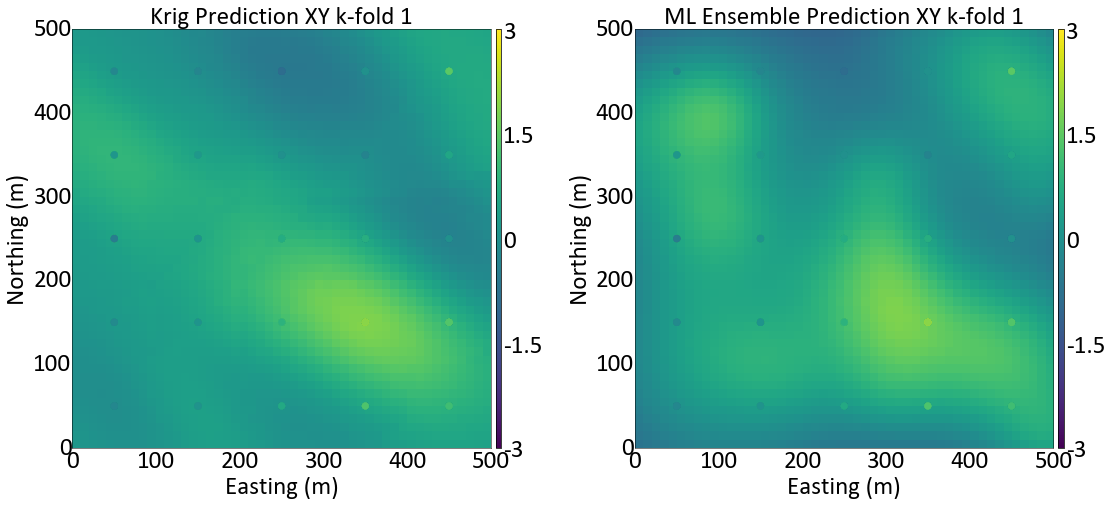

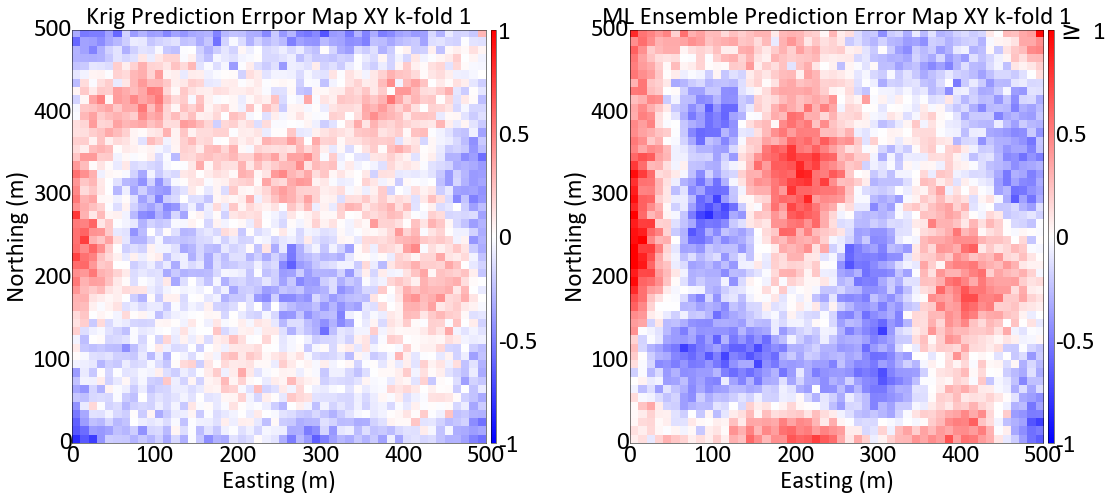

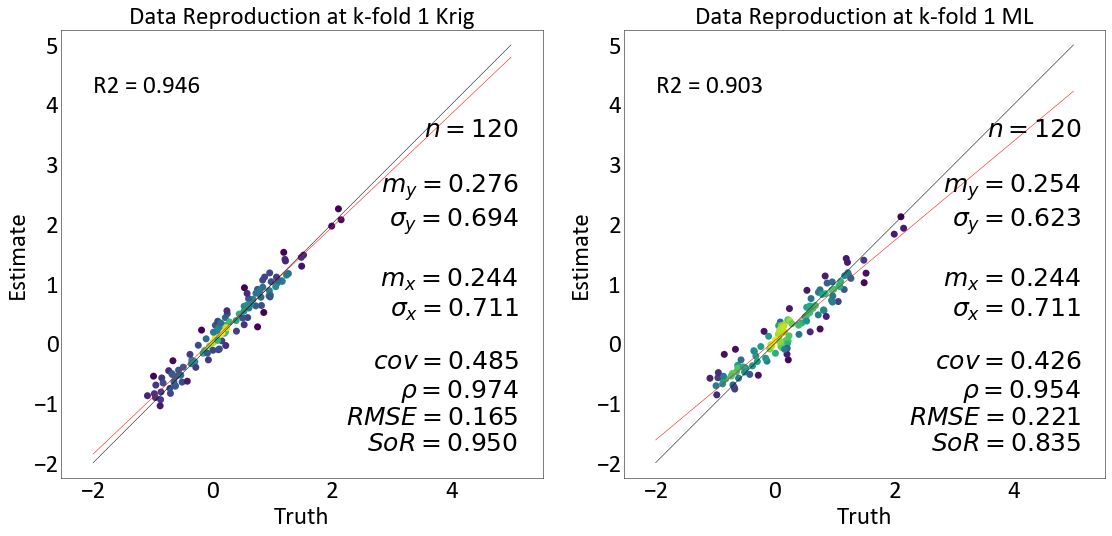

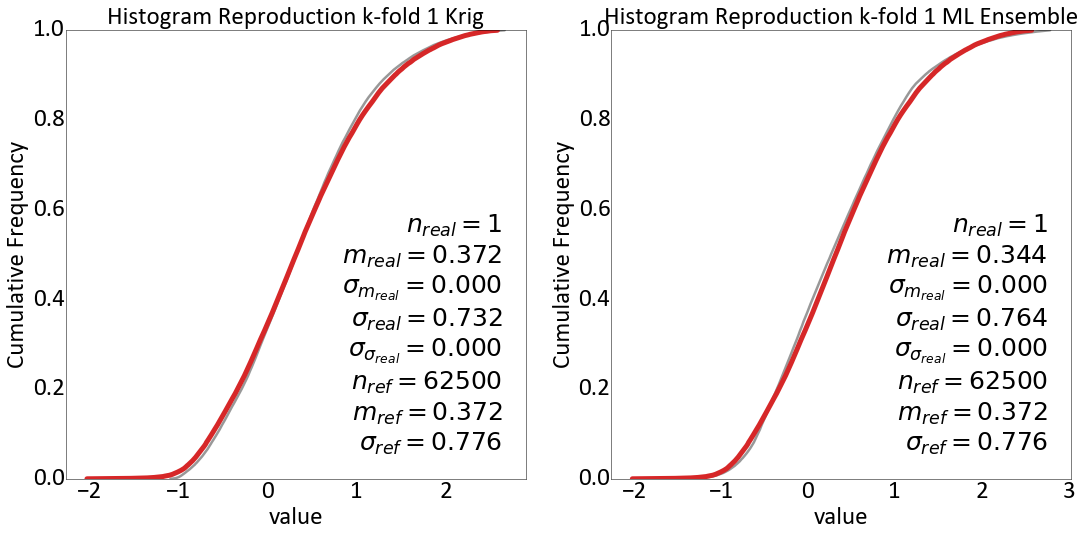

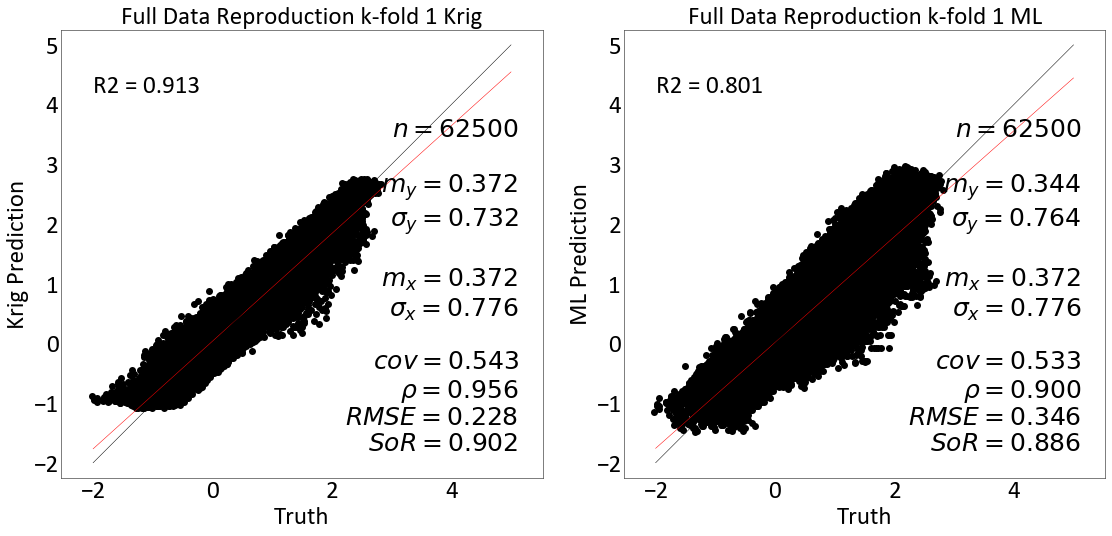

the r2 for krig k-fold 0.9460020225549932
the r2 for ML k-fold 0.9032354107698618
the r2 for krig full 0.9132707629804028
the r2 for ML full 0.8007875785423163


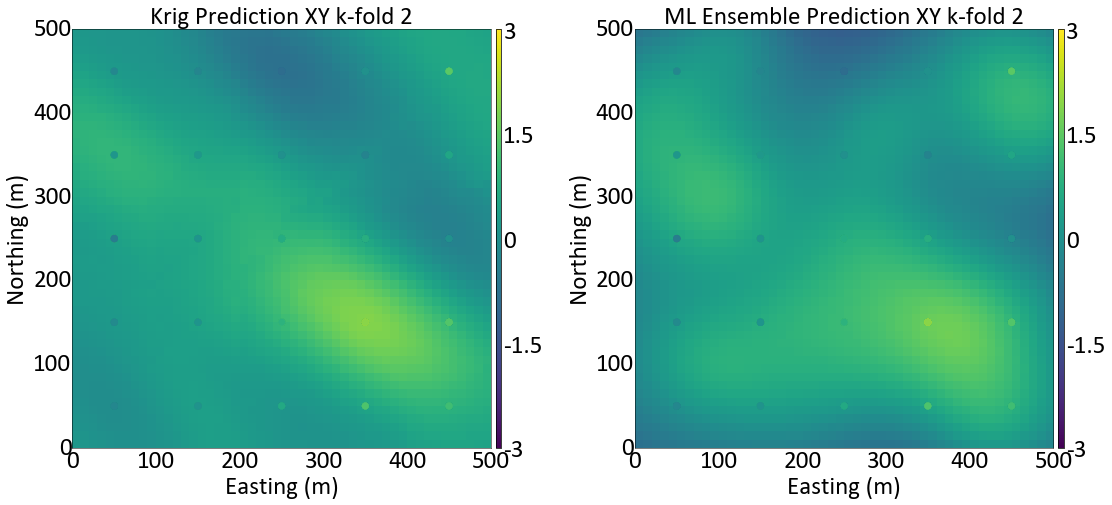

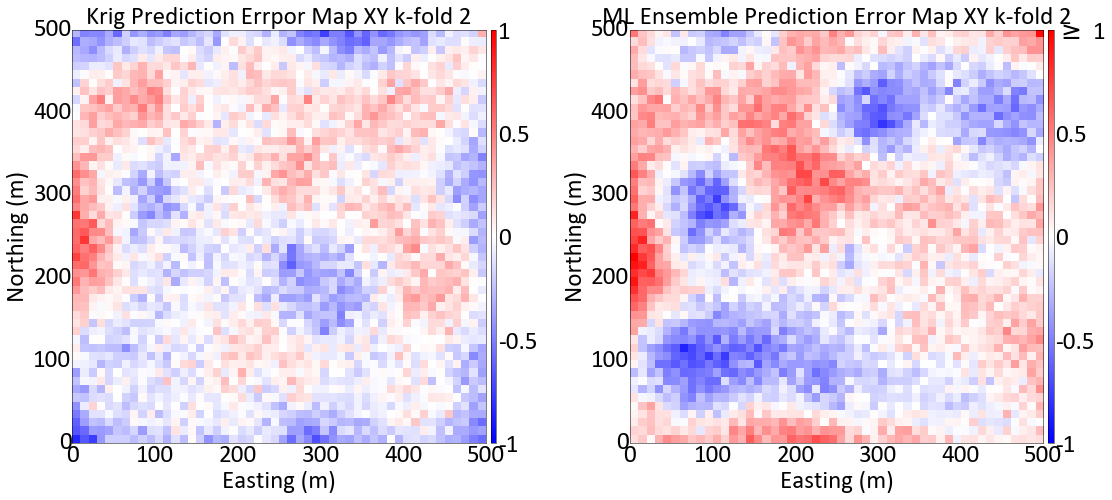

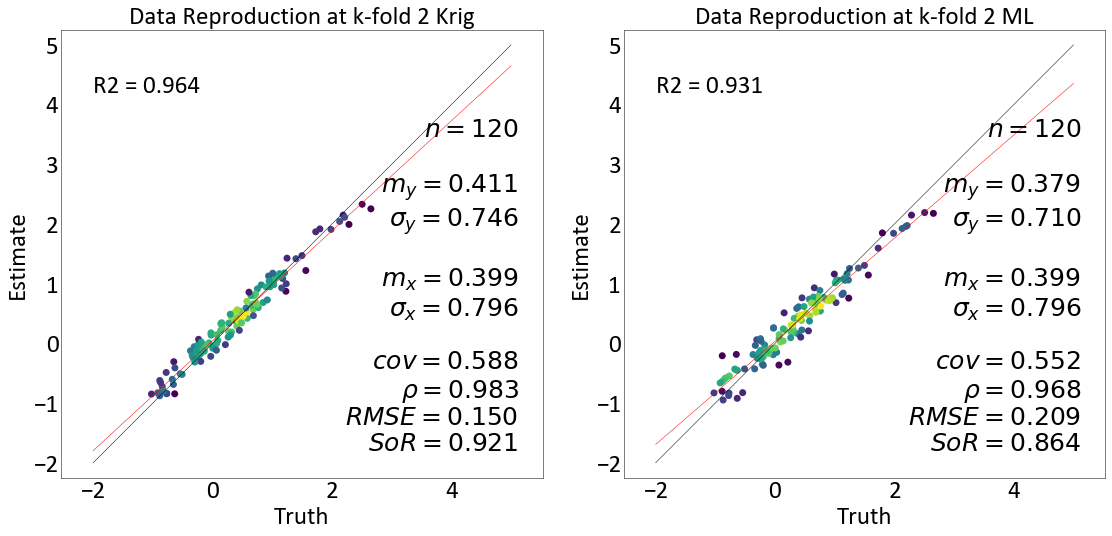

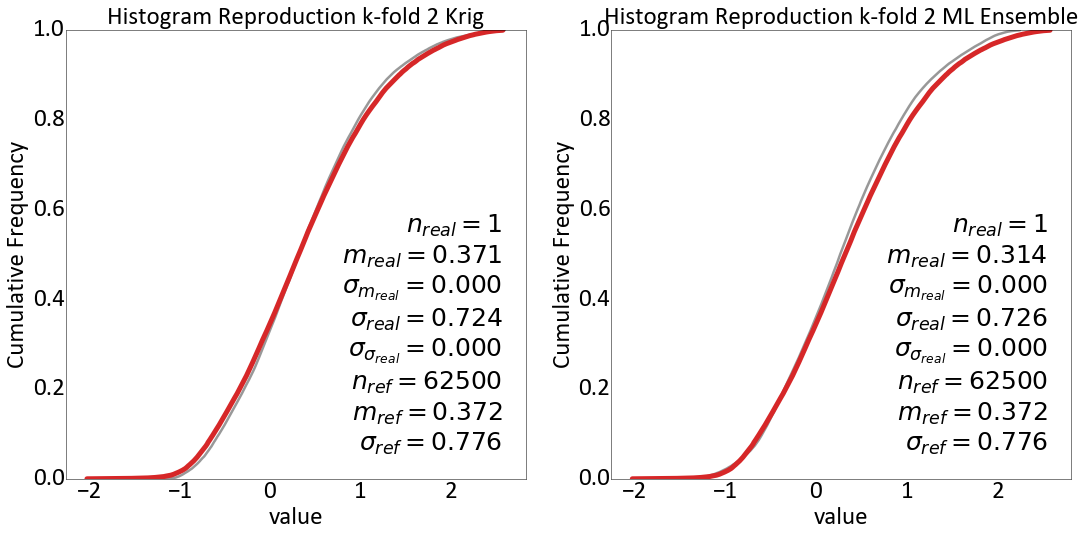

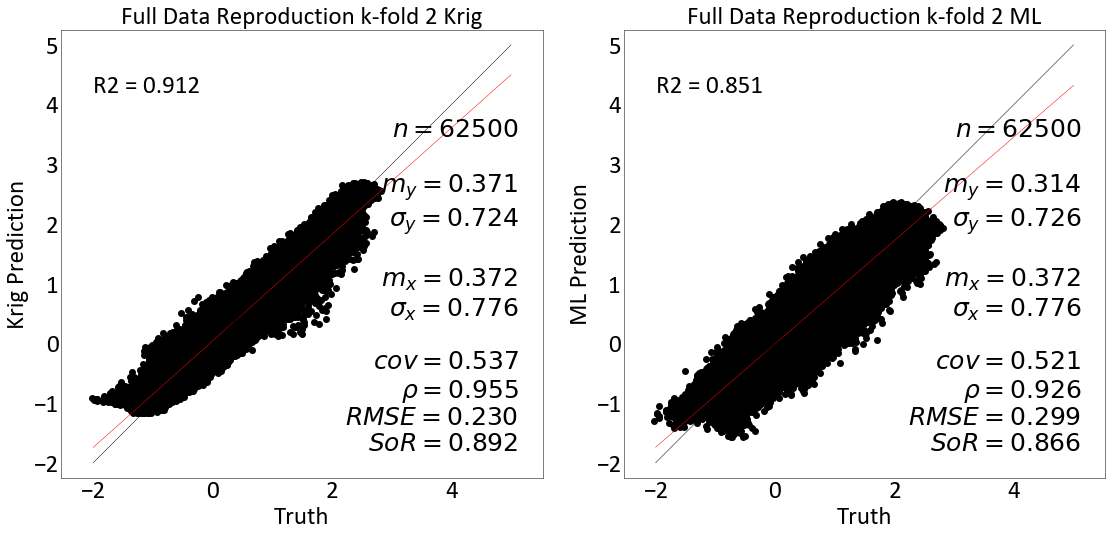

the r2 for krig k-fold 0.9643779601295177
the r2 for ML k-fold 0.9307648312490437
the r2 for krig full 0.9123248291259796
the r2 for ML full 0.8512981686936363


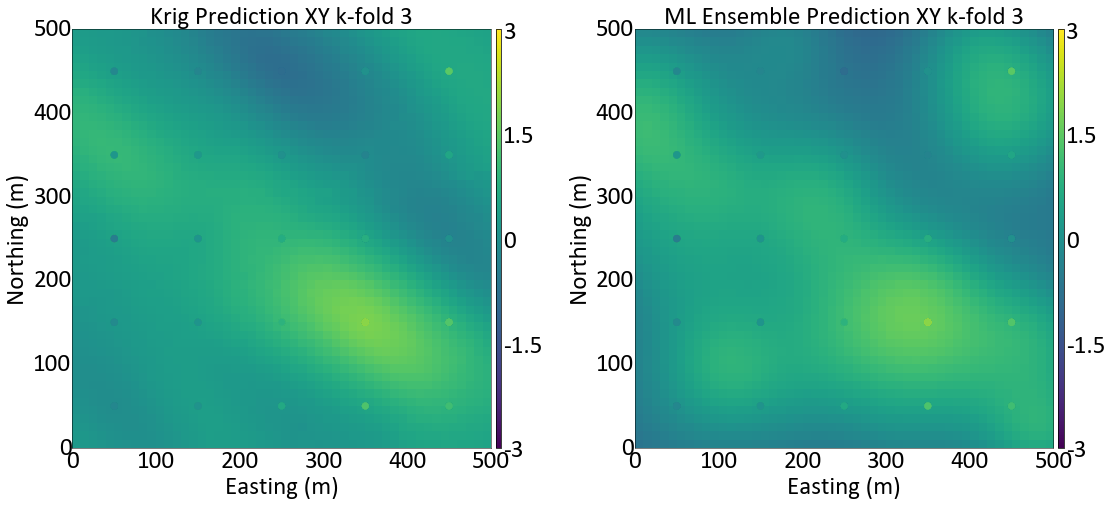

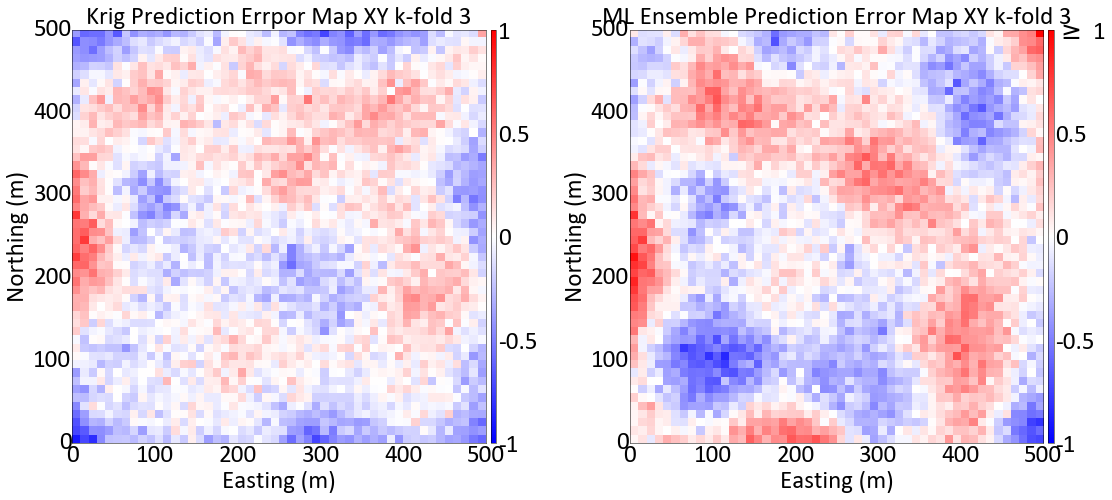

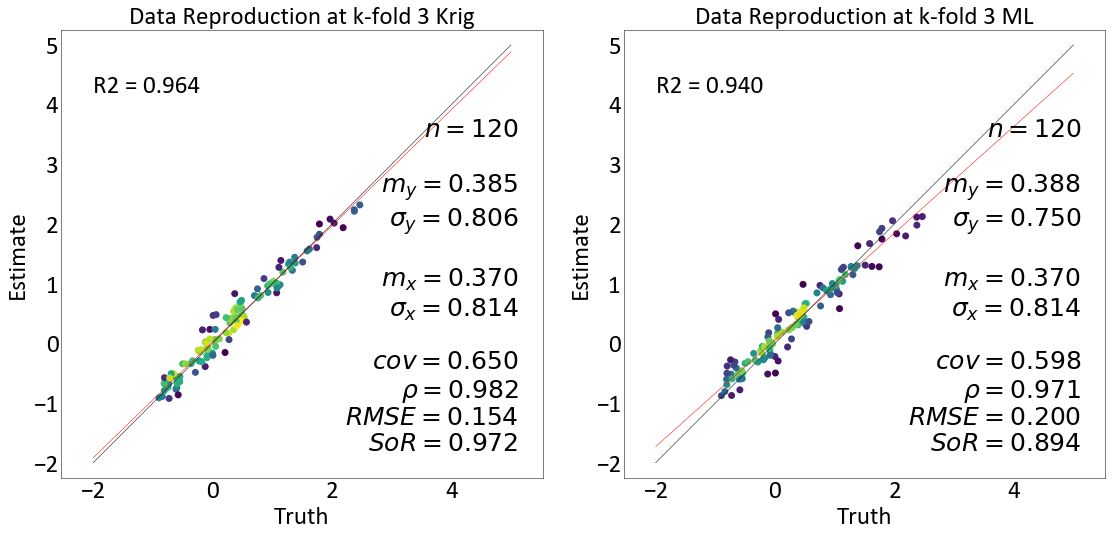

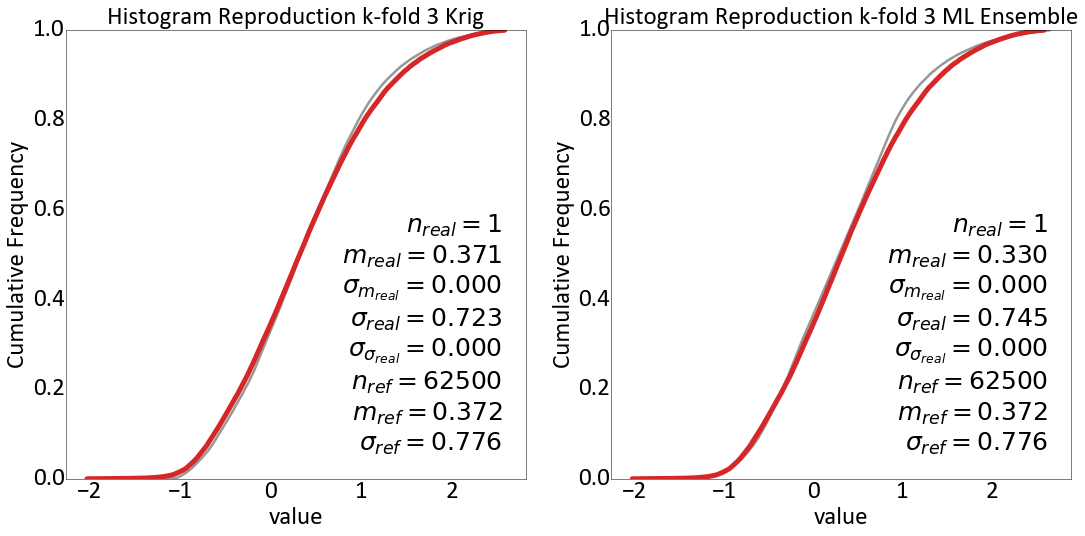

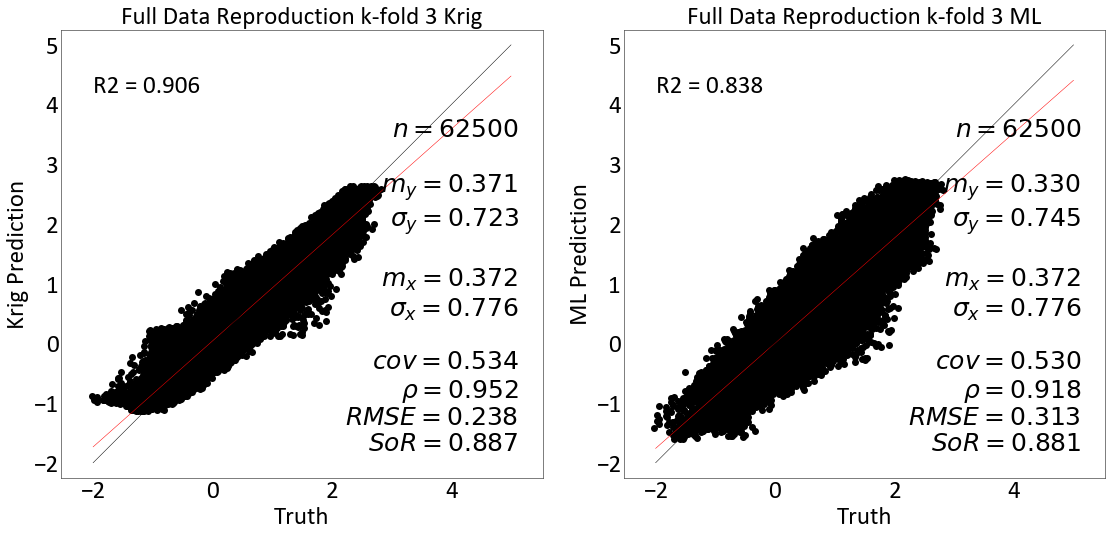

the r2 for krig k-fold 0.9640604999853183
the r2 for ML k-fold 0.9398600926969899
the r2 for krig full 0.9061993994475348
the r2 for ML full 0.8376126549013414


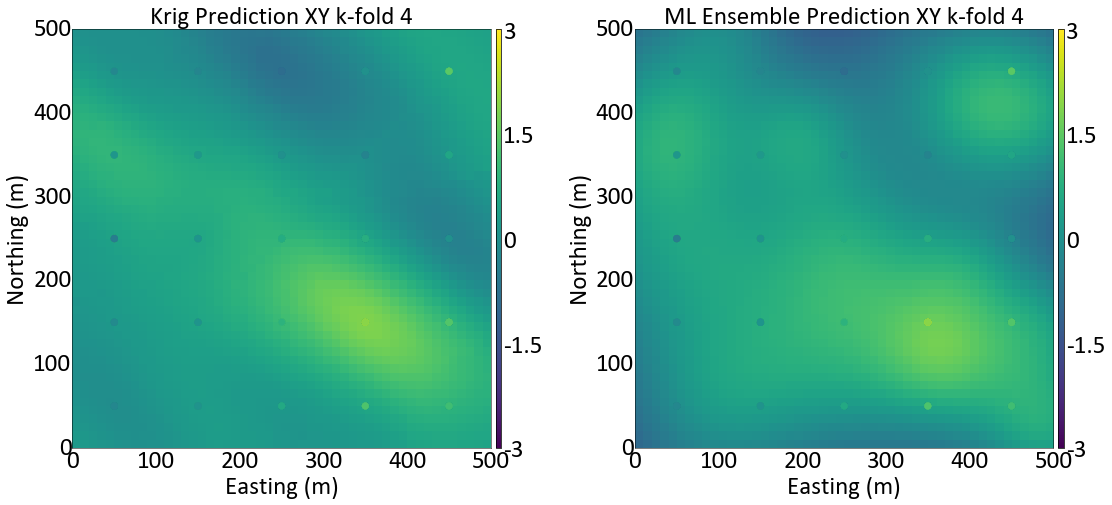

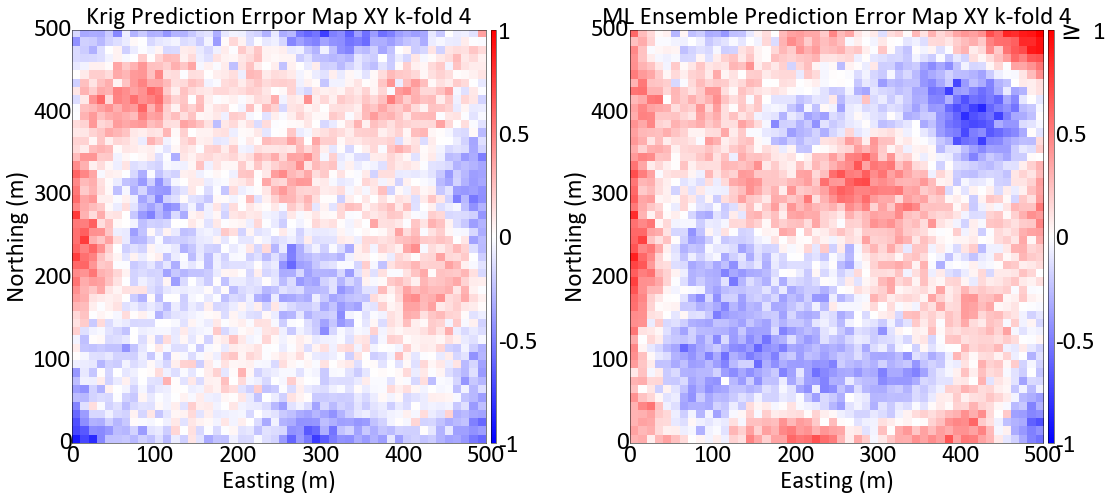

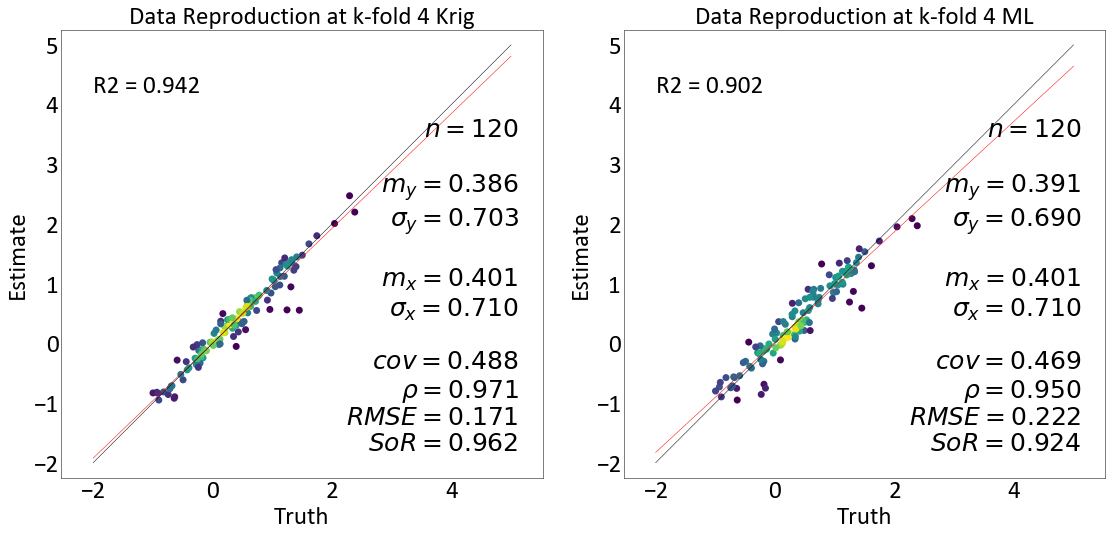

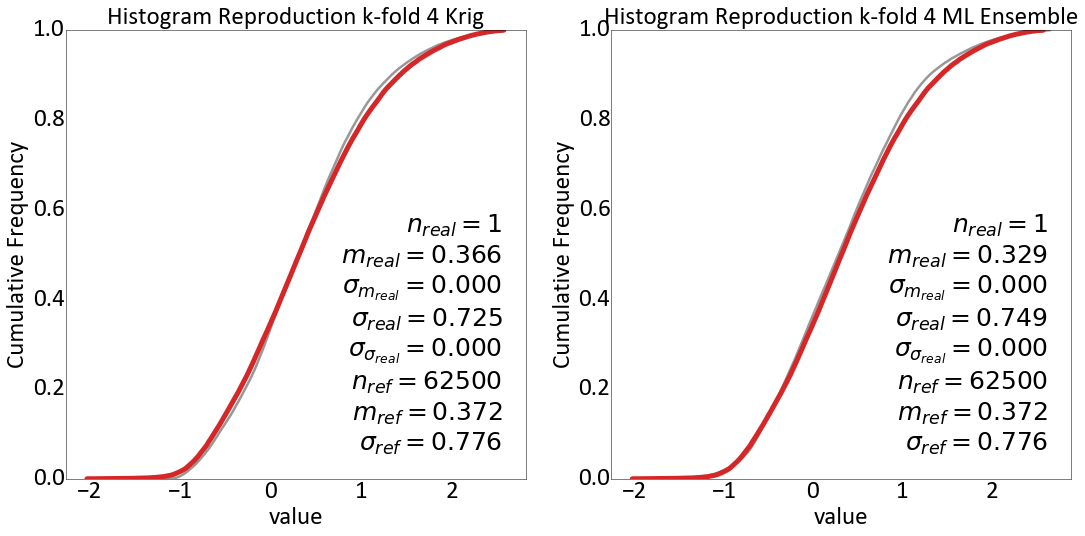

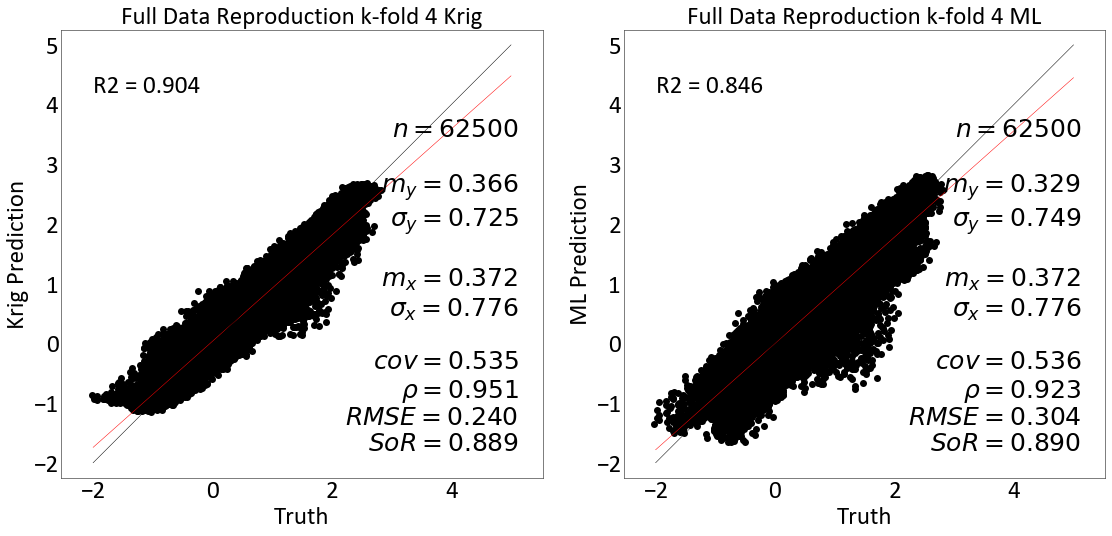

the r2 for krig k-fold 0.9420343172196656
the r2 for ML k-fold 0.9018340193999019
the r2 for krig full 0.9042055651664942
the r2 for ML full 0.8463817411745311


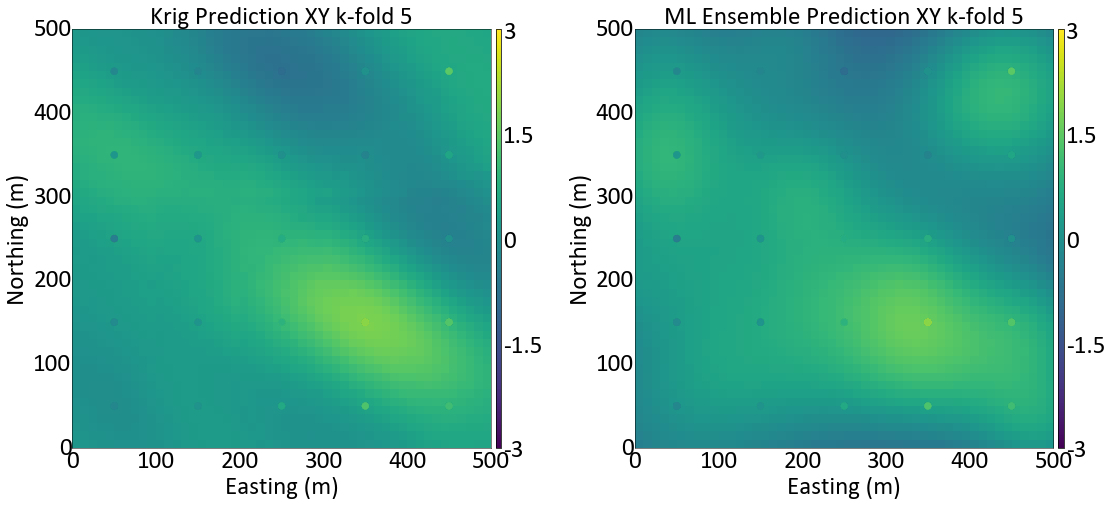

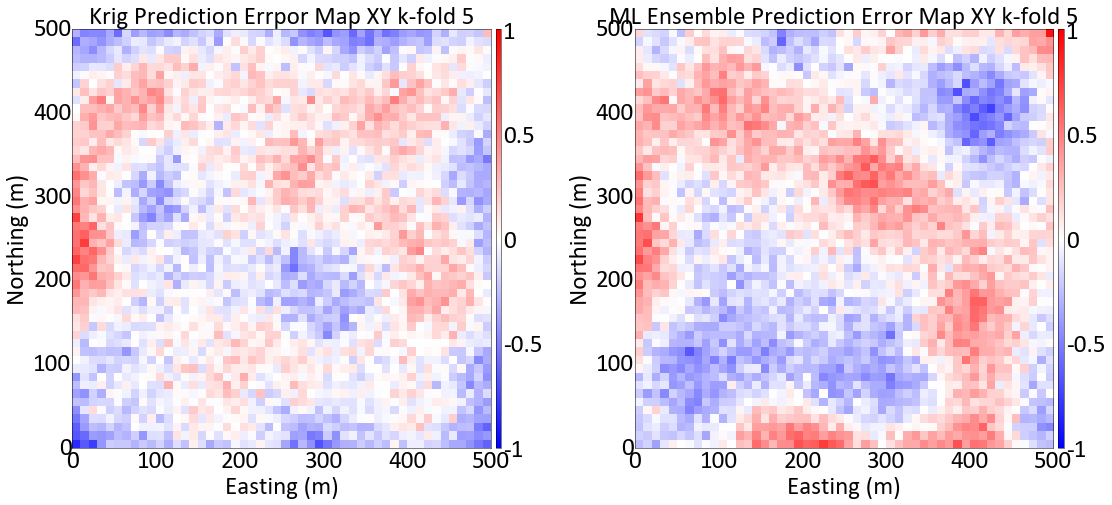

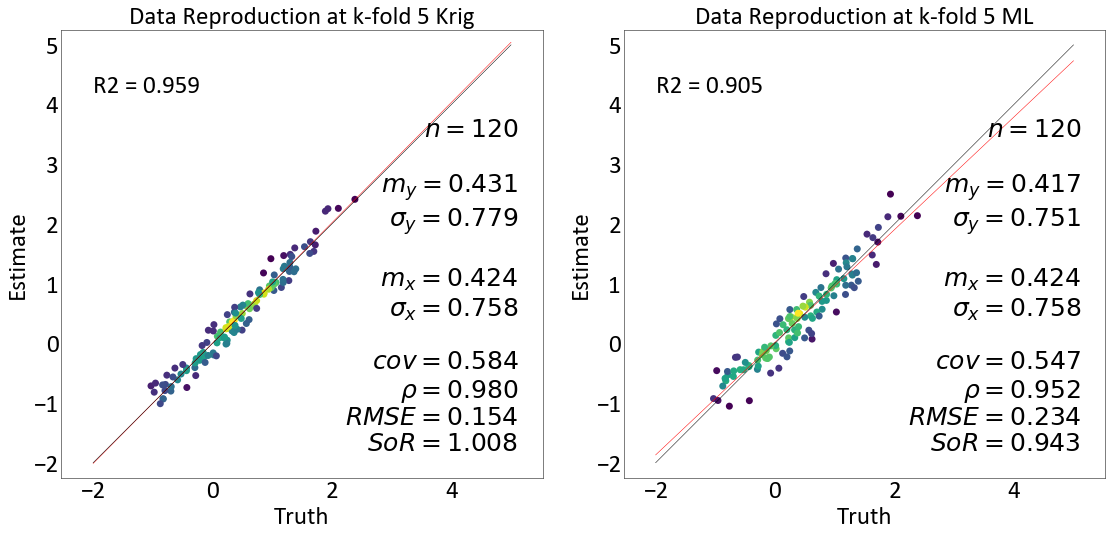

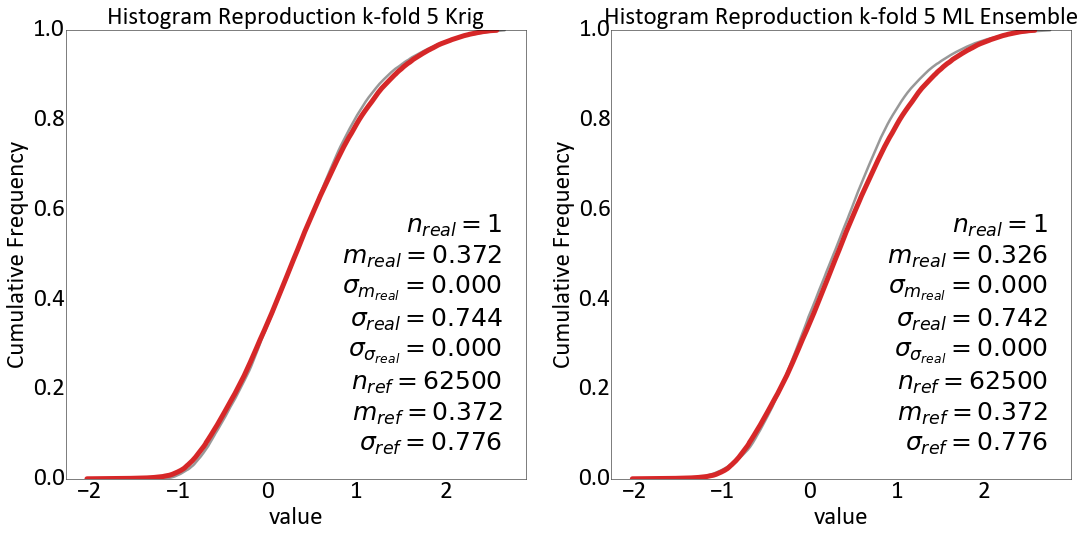

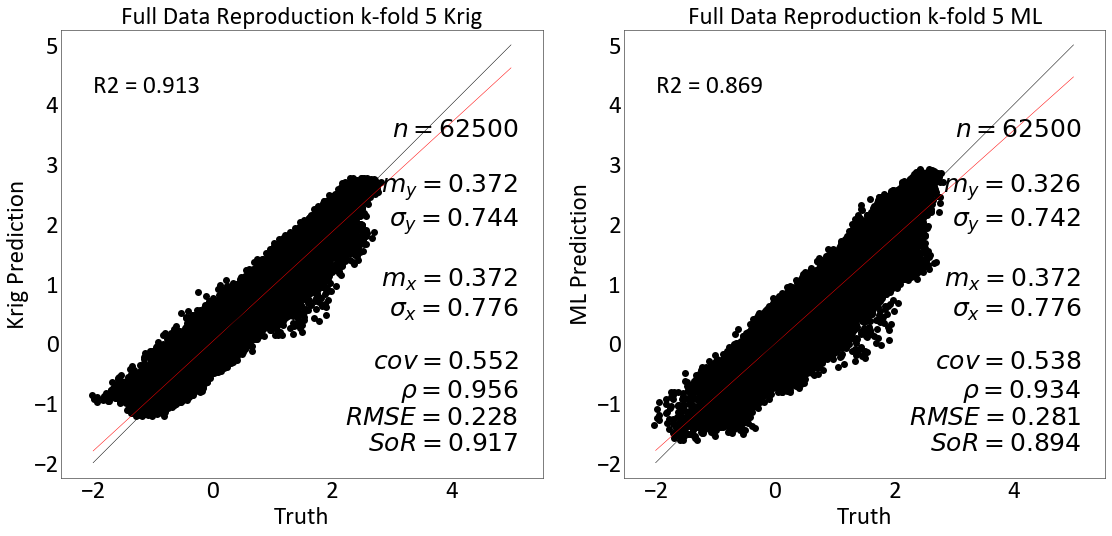

the r2 for krig k-fold 0.9588334144009707
the r2 for ML k-fold 0.9050532666161895
the r2 for krig full 0.9134790540994123
the r2 for ML full 0.8691100670273169
the average r2 of the krig is 0.955061642858093
the average r2 of the ML is 0.9161495241463973
the average rmse of the krig is 0.15909749175615964
the average rmse of the ML is 0.21757097920055116
the average r2 of the full model for krig is 0.9098959221639648
the average r2 of the full model for ML is 0.8410380420678283
the average rmse of the full model for krig is 0.23287199585262103
the average rmse of the full model for ML is 0.3093083497426473


In [4]:
sgsimfl = gs.DataFile(flname = 'sgsim.out', griddef=griddef,readfl=True)
dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
                       readfl=True)
gs.set_style('pt25')
datasamplefl = pd.DataFrame(dataflpoints.data, dtype = np.float32)
del datasamplefl['Drill ID']
del datasamplefl['MD']
del datasamplefl['Block ID']
datasamplefl = datasamplefl[pd.notnull(datasamplefl['value'])]
datasamplefl.describe()
datatest = np.asmatrix(datasamplefl)
slinceno=20
vlim =(-3,3)
r2_krg = 0
r2_ML = 0
i=0
mse_krg = 0
mse_ML = 0
r2_krg_full = 0 
r2_ML_full = 0
mse_krg_full = 0
mse_ML_full = 0
mse_ML_icck = 0
r2_ML_icck = 0
r2_ML_icck_full = 0
mse_ML_icck_full = 0

var = 'value'
sigma = 0
for fold in range(1,6):
    i += 1
    testfile = gs.DataFile('./data/data_test_{}.dat'.format(fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
    pltdat_ml = gs.DataFile('./predictions/ensemble_{}.dat'.format(fold),griddef=griddef)
    pltdat_ml = (gaussian_filter((pltdat_ml.data['0']),sigma = 0))
#    pltdat_ml[pltdat_ml < 0] = 0
#     pltdat_ml_icck = gs.DataFile('./backtr/backtr_UDDH_{}.out'.format(fold),griddef=griddef)
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['X'],y=testfile.data['Y'],z=testfile.data['Z'])
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')

    ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
                title = 'Krig Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'Krig Prediction XY k-fold {}'.format(fold))

    ax3 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[1],
                title = 'ML Ensemble Prediction XY k-fold {}'.format(fold),vlim=vlim, sliceno=slinceno)
    ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML Ensemble Prediction XY k-fold {}'.format(fold))

    #ax4 = gs.pixelplt(pltdat_ml_icck,griddef=griddef,var = 'Back Transform' ,ax = axes[2],
                #title = 'ML prediction XY ensemble',vlim=vlim, sliceno=slinceno)
#    ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML+ICCK prediction XY')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/pix_xy_04_{}.png'.format(fold))
    plt.show()
    
    f, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.pixelplt((sgsimfl.data['value']-pltdat_kt3dn.data['Estimate']),ax = axes[0],
                title = 'Krig Prediction Errpor Map XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr',griddef=griddef)
    #ax2 = gs.locmap(datasamplefl,griddef=griddef, ax=ax2,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'krig prediction XY', orient = 'xz')

    ax3 = gs.pixelplt((sgsimfl.data['value']-pltdat_ml),griddef=griddef,ax = axes[1],
                title = 'ML Ensemble Prediction Error Map XY k-fold {}'.format(fold),vlim=(-1,1), sliceno=slinceno, orient = 'xy',cmap = 'bwr')
    #ax3 = gs.locmap(datasamplefl,griddef=griddef, ax=ax3,sliceno=slinceno,x='X', y='Y', z='Z', var = var , vlim=vlim,title = 'ML prediction XY ensemble', orient = 'xz')
    
    #ax4 = gs.pixelplt(pltdat_ml_icck,griddef=griddef,var = 'Back Transform' ,ax = axes[2],
                #title = 'ML prediction XY ensemble',vlim=vlim, sliceno=slinceno, orient = 'xz')
#    ax4 = gs.locmap(datasamplefl,griddef=griddef, ax=ax4,sliceno=slinceno,x='X', y='Y', z='Z',orient = 'xz',var = var , vlim=vlim,title = 'ML+ICCK prediction XY')
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/error_xy_04_{}.png'.format(fold))
    plt.show()
    
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.scatxval(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values,xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} Krig'.format(fold),dens=True,ax = axes[0],vlim=(-2,5))
    
    ax2.text(-2.0,4.2,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx].values)),size=25)
    
    ax3 = gs.scatxval(testfile.data[var],pltdat_ml[idx],xlabel='Truth', ylabel='Estimate',
        title = 'Data Reproduction at k-fold {} ML'.format(fold),dens=True,ax = axes[1],vlim=(-2,5))
    ax3.text(-2.0,4.2,'R2 = {0:.3f}'.format(r2_score(testfile.data[var],pltdat_ml[idx])),size=25)
    
#    ax4 = gs.scatxval(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx].values,xlabel='Truth', ylabel='Estimate',
        #title = 'Data Reproduction at k-fold {} ML+ICCK'.format(fold),dens=True,ax = axes[2])
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/kfold_datarep_04_{}.png'.format(fold))
    plt.show()
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    ax2 = gs.histpltsim(pltdat_kt3dn.data['Estimate'],sgsimfl['value'],ax=axes[0],lw=5,title = 'Histogram Reproduction k-fold {} Krig'.format(fold),griddef=griddef,nreal=1)


    ax3 = gs.histpltsim(pltdat_ml,sgsimfl['value'],ax=axes[1],lw=5,title = 'Histogram Reproduction k-fold {} ML Ensemble'.format(fold),griddef=griddef,nreal=1)

#    ax4 = gs.histpltsim(pltdat_ml_icck.data['Back Transform'],sgsimfl['Var1'],ax=axes[2],griddef=griddef,nreal=1)
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/histsim_04_{}.png'.format(fold))
    plt.show()
    
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
#    axes[2].set_aspect('equal', 'box')
    
    ax2 = gs.scatxval(sgsimfl['value'],pltdat_kt3dn.data['Estimate'],ax=axes[0],griddef=griddef,xlabel='Truth',vlim=(-2,5),
                      title = 'Full Data Reproduction k-fold {} Krig'.format(fold), ylabel ='Krig Prediction',desn=True)
    ax2.text(-2.0,4.2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])),size=25)

    ax3 = gs.scatxval(sgsimfl['value'],pltdat_ml,ax=axes[1],griddef=griddef,xlabel='Truth',ylabel='ML Prediction',vlim=(-2,5),
                      title = 'Full Data Reproduction k-fold {} ML'.format(fold),label ='ML Prediction',desn=True)
    ax3.text(-2.0,4.2,'R2 = {0:.3f}'.format(r2_score(sgsimfl['value'],pltdat_ml)),size=25)
    
#    ax4 = gs.scatxval(sgsimfl['Var1'],pltdat_ml_icck.data['Back Transform'],ax=axes[2],griddef=griddef,xlabel='Truth', ylabel ='ML+ICCK Prediction',vlim =vlim)
    plt.tight_layout()
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/full_datarep_04_{}.png'.format(fold))
    plt.show()
    
    print('the r2 for krig k-fold {}'.format(r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])))
    print('the r2 for ML k-fold {}'.format(r2_score(testfile.data[var],pltdat_ml[idx])))
    print('the r2 for krig full {}'.format(r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])))
    print('the r2 for ML full {}'.format(r2_score(sgsimfl['value'],pltdat_ml)))
    
    
    
    mse_krg = mse_krg + mean_squared_error(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    mse_ML = mse_ML + mean_squared_error(testfile.data[var],pltdat_ml[idx])
#    mse_ML_icck = mse_ML_icck + mean_squared_error(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg = r2_krg + r2_score(testfile.data[var],pltdat_kt3dn.data['Estimate'][idx])
    r2_ML = r2_ML + r2_score(testfile.data[var],pltdat_ml[idx])
#    r2_ML_icck = r2_ML_icck + r2_score(testfile.data[var],pltdat_ml_icck.data['Back Transform'][idx])
    r2_krg_full = r2_krg_full + r2_score(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    r2_ML_full = r2_ML_full + r2_score(sgsimfl['value'],pltdat_ml)
#    r2_ML_icck_full = r2_ML_icck_full + r2_score(sgsimfl['Var1'].values,pltdat_ml_icck.data['Back Transform'].values)
    mse_krg_full = mse_krg_full + mean_squared_error(sgsimfl['value'],pltdat_kt3dn.data['Estimate'])
    mse_ML_full = mse_ML_full + mean_squared_error(sgsimfl['value'],pltdat_ml)
#     mse_ML_icck_full = mse_ML_icck_full + mean_squared_error(sgsimfl['Var1'],pltdat_ml_icck.data['Back Transform'])
    
    gs.write_gslib(pd.DataFrame(pltdat_ml),'./predictions/ML_pred_{}.dat'.format(fold))
    
print('the average r2 of the krig is {}'.format(r2_krg/i))
print('the average r2 of the ML is {}'.format(r2_ML/i))
#print('the average r2 of the ML_ICCK is {}'.format(r2_ML_icck/i))
print('the average rmse of the krig is {}'.format(np.sqrt(mse_krg/i)))
print('the average rmse of the ML is {}'.format(np.sqrt(mse_ML/i)))
#print('the average rmse of the ML_icck is {}'.format(np.sqrt(mse_ML_icck/i)))
print('the average r2 of the full model for krig is {}'.format(r2_krg_full/i))
print('the average r2 of the full model for ML is {}'.format(r2_ML_full/i))
#print('the average r2 of the full model for ML_icck is {}'.format(r2_ML_icck_full/i))
print('the average rmse of the full model for krig is {}'.format(np.sqrt(mse_krg_full/i)))
print('the average rmse of the full model for ML is {}'.format(np.sqrt(mse_ML_full/i)))
#print('the average rmse of the full model for ML_icck is {}'.format(np.sqrt(mse_ML_icck_full/i)))

In [12]:
# dataflpoints = gs.DataFile(flname='dhs.out', x='X',y='Y',z='Z', griddef = griddef,
#                        readfl=True)
# f, axes = plt.subplots(2, 2, figsize=(16, 16))
# gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[0,0], griddef = griddef,  title = 'Simulated Truth XY')
# gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[0,1], griddef = griddef,orient='xy', title = 'Location Map of Drill Holes XY')
# gs.pixelplt(sgsimfl.data['value'], vlim=vlim, ax = axes[1,0], griddef = griddef,orient='xz', title = 'Simulated Truth XZ')
# gs.locmap(dataflpoints,var = 'value' ,vlim=vlim, ax = axes[1,1], griddef = griddef,orient='xz', title = 'Location Map of Drill Holes XZ')
# plt.tight_layout()
# plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/Data_01.png')
# plt.show()

In [13]:
varsim = gs.Program('varsim')
varsimparstr = """                 Parameters for VarSim
                 *********************

START OF PARAMETERS:
../data/lithology.dat        -file with lithology information
0   7                        -   lithology column (0=not used), code
{datafl}             -file with data
1   1                -   number of variables, column numbers
-1.0e21     1.0e21    -   trimming limits
./vargs/varsim_reals_{p_type}_{fold}.out      -output file for variograms of realizations
./vargs/varsim_avg_{p_type}_{fold}.out        -output file for average variogram
{griddef}
1                  -number of realizations
3  100                 -number of directions, number of lags
1  0  0              -ixd(1),iyd(1),izd(1)
0  1  0              -ixd(2),iyd(2),izd(2)
0  0  1              -ixd(2),iyd(2),izd(2)
0                     -standardize sill? (0=no, 1=yes)
1                     -number of variograms
1   1   1             -tail variable, head variable, variogram type
"""

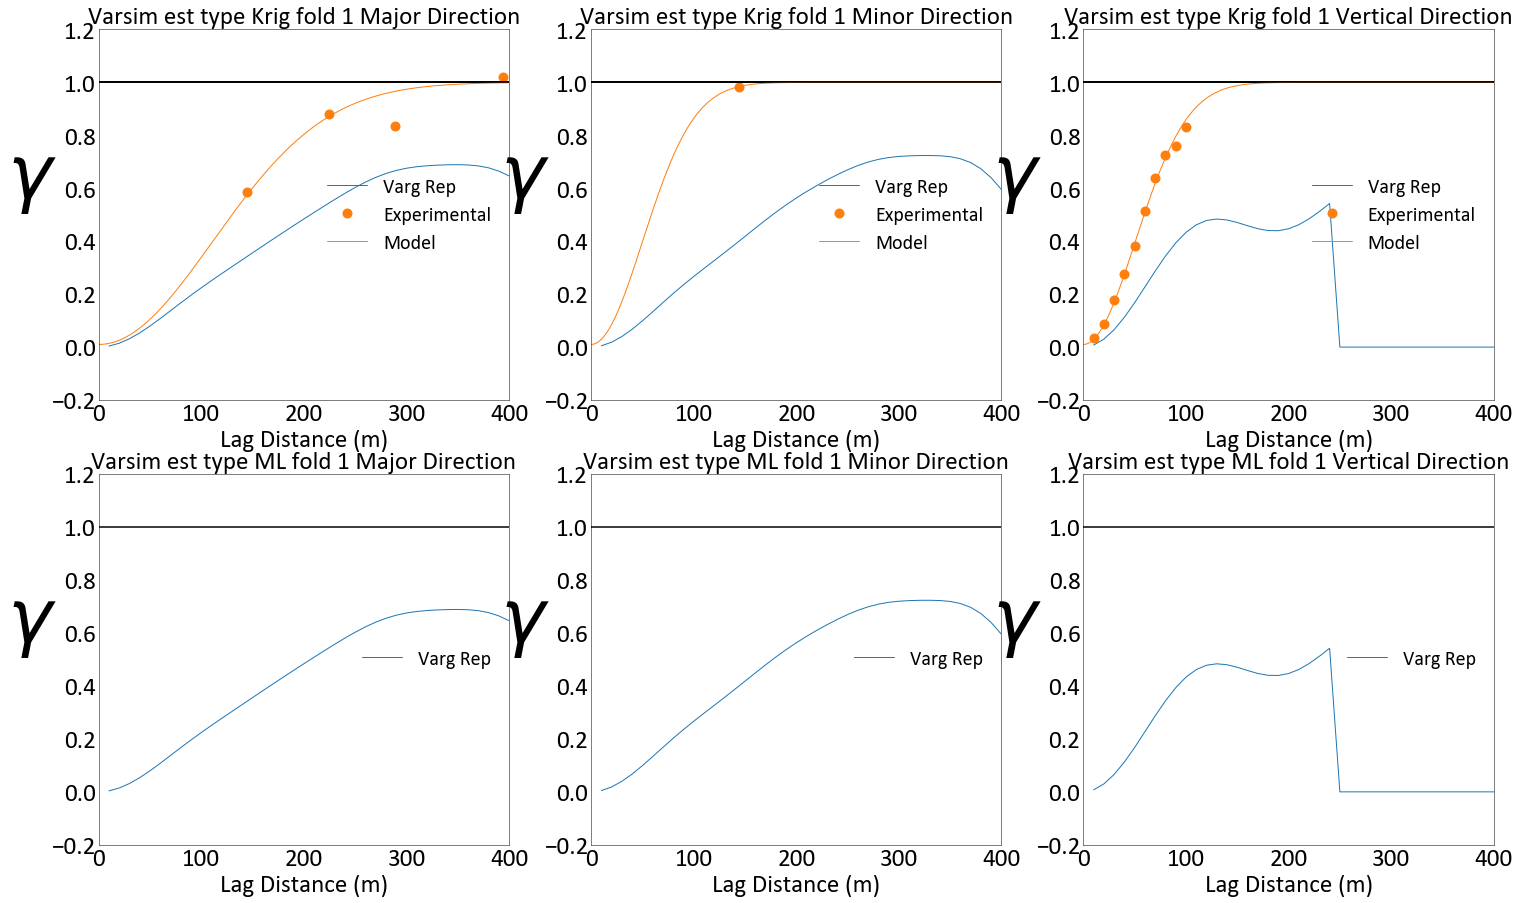

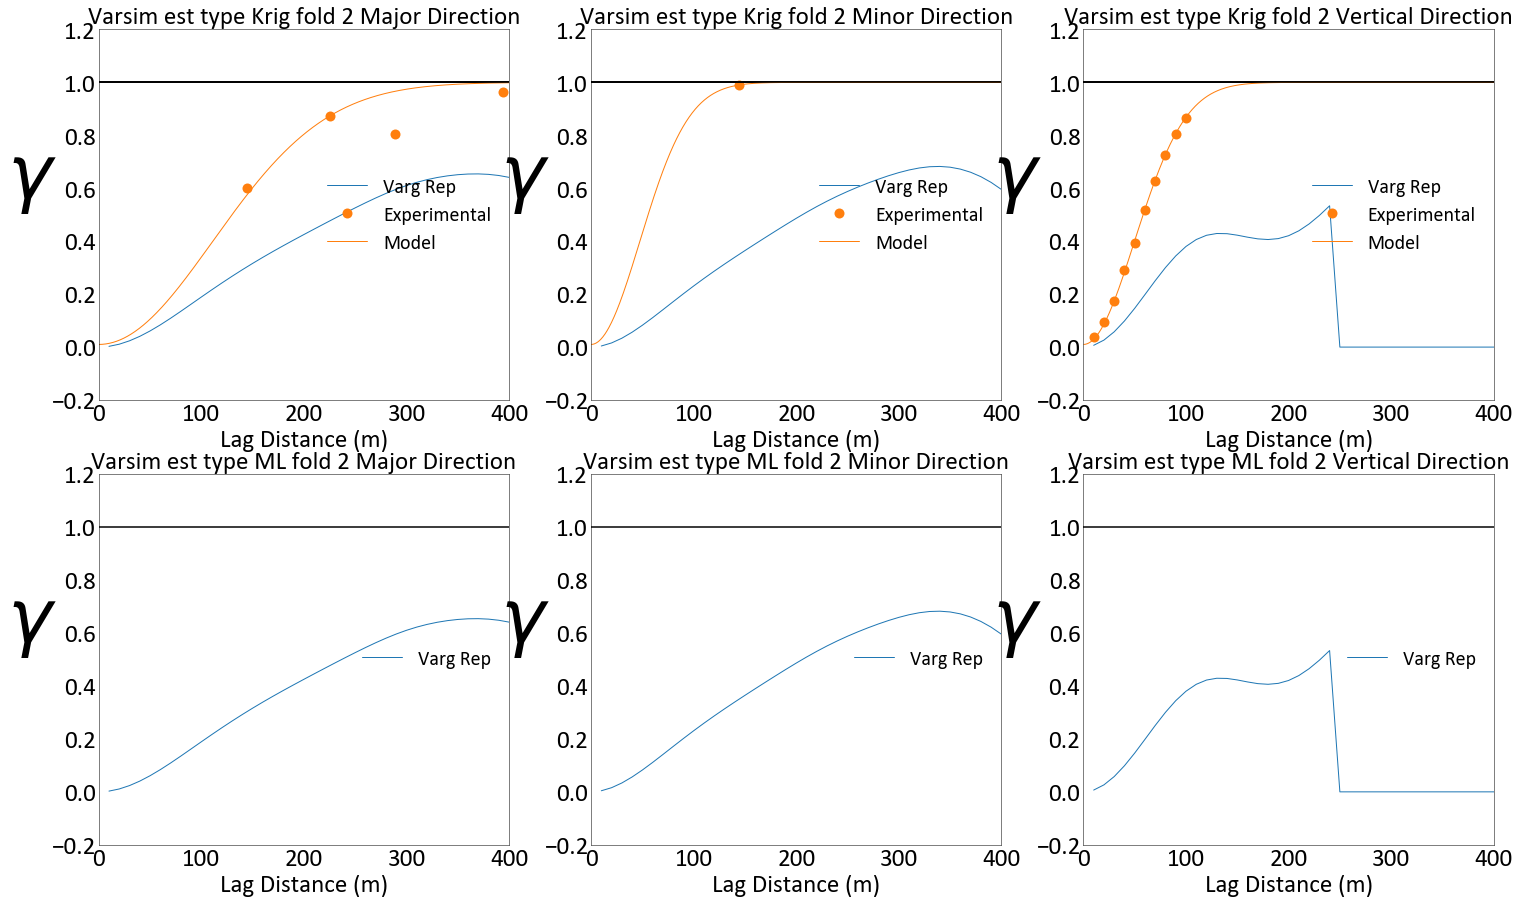

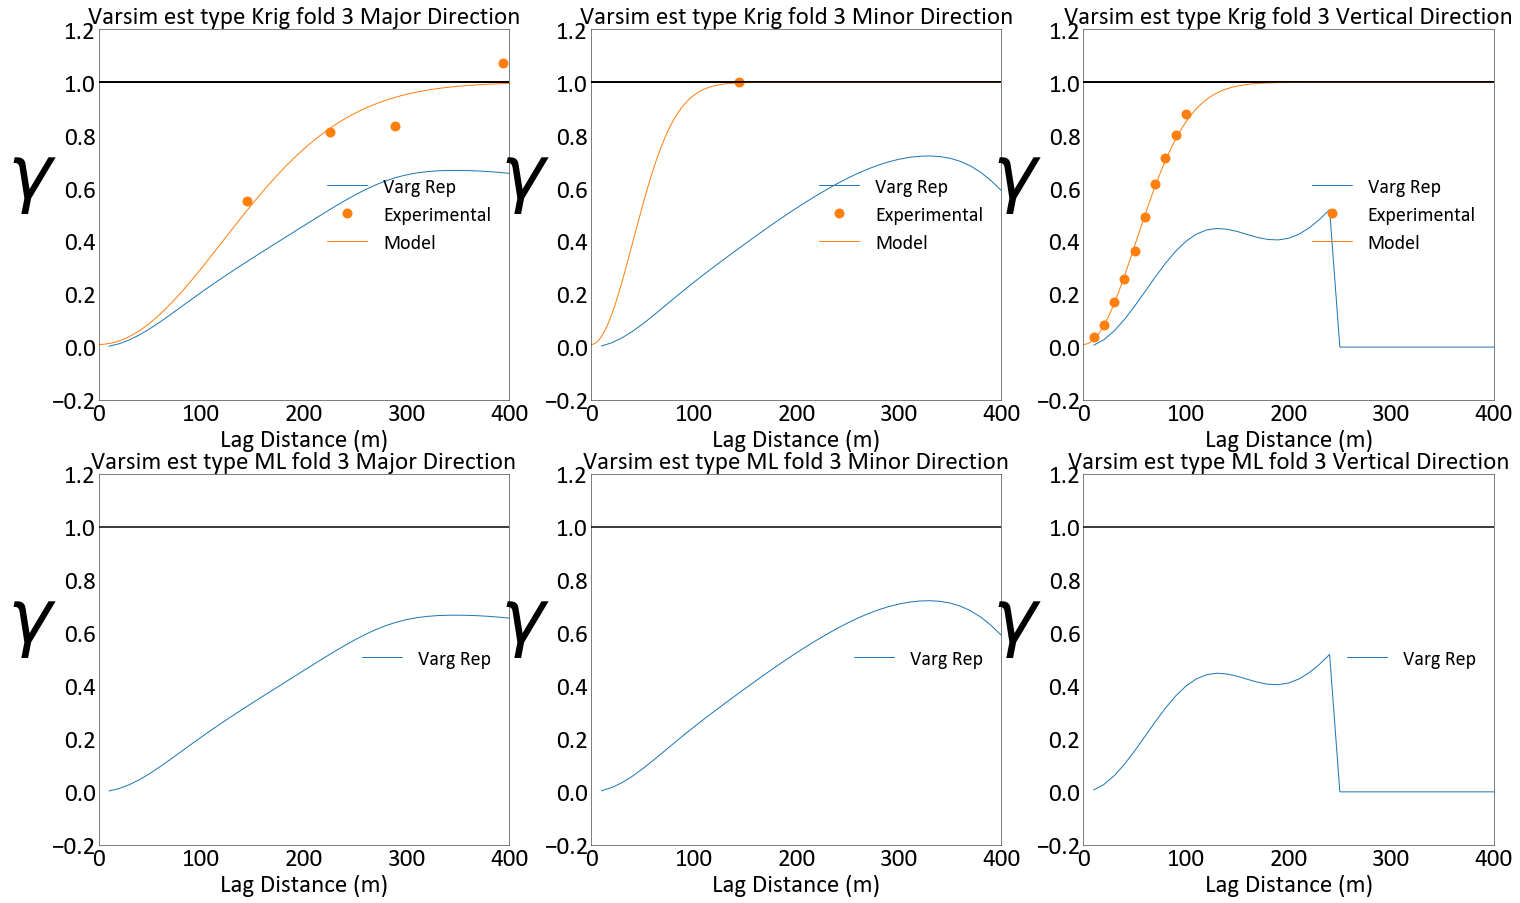

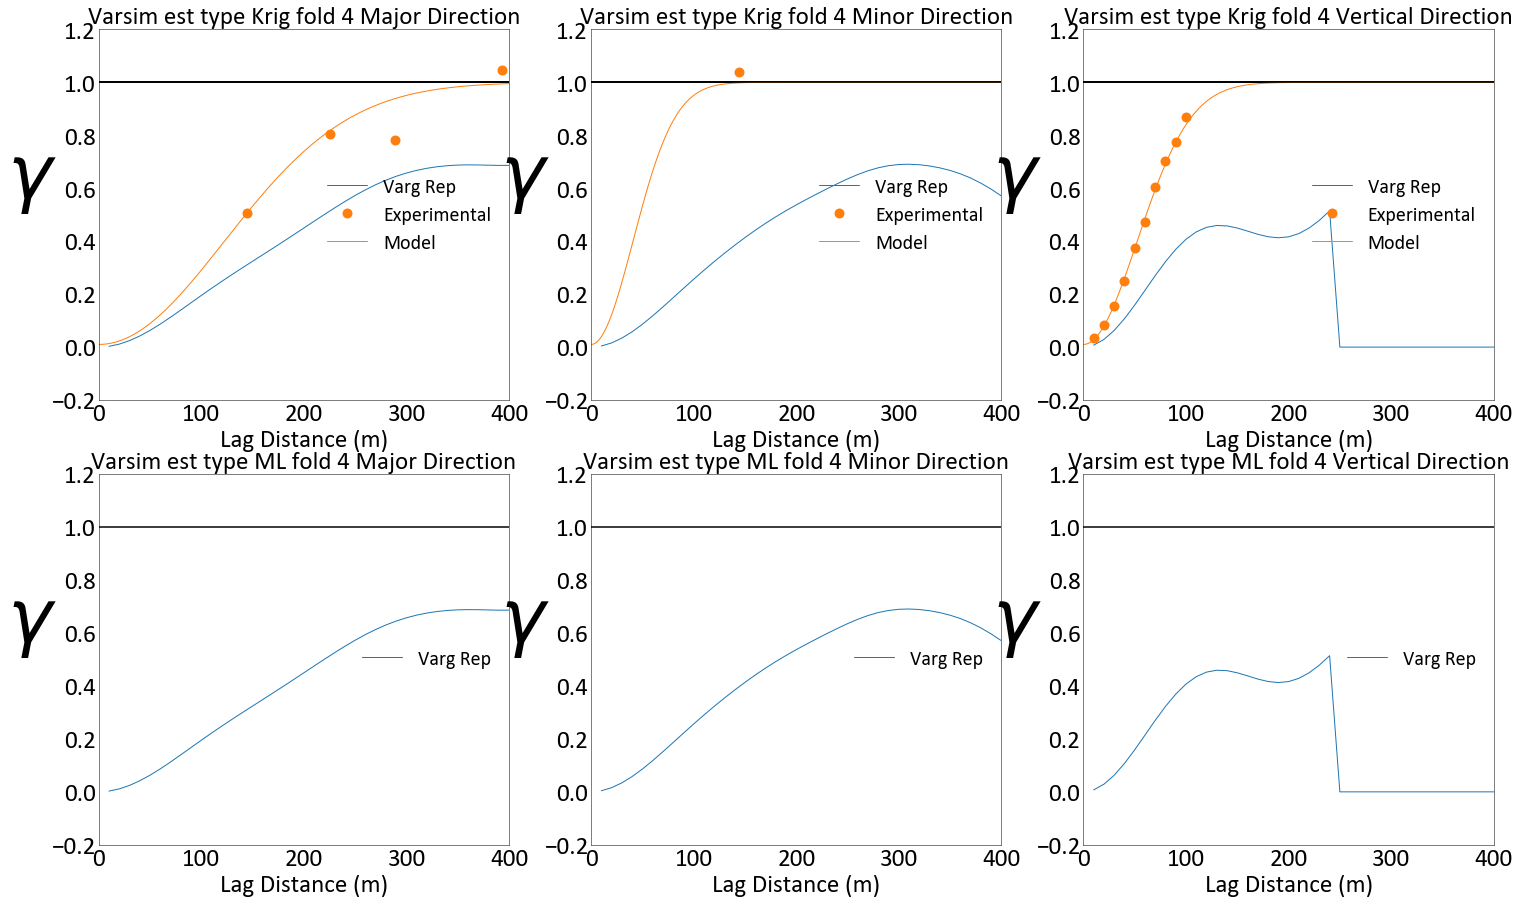

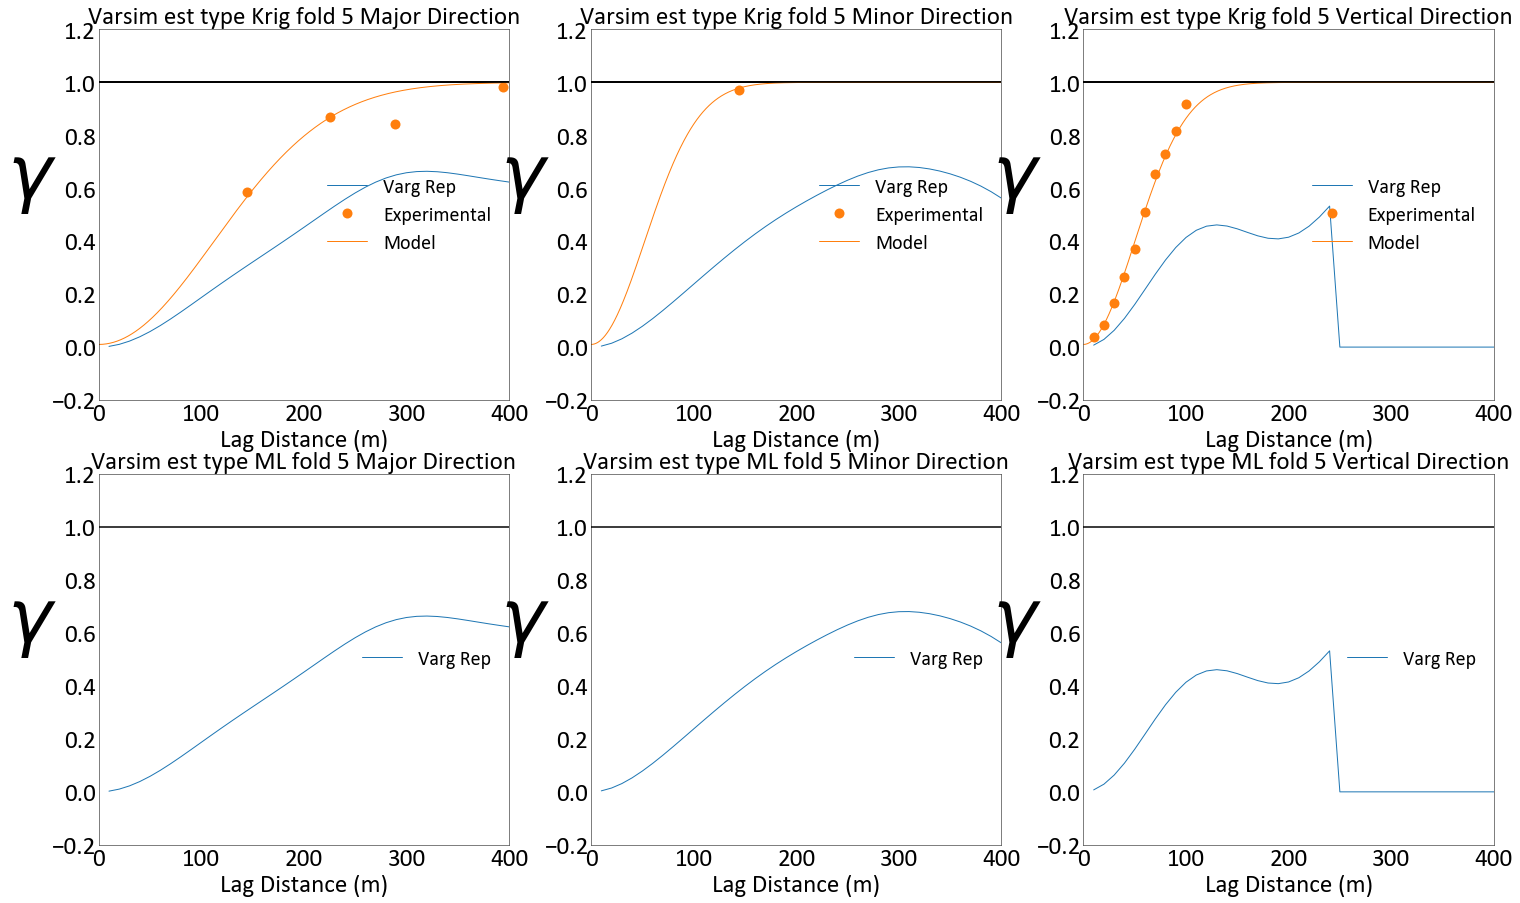

In [14]:
ylim = (-.2,1.2)
for fold in range(1,6):
    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))
    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))
    f, axes = plt.subplots(2, 3, figsize=(25, 15))
    for p_type in list(['Krig','ML']):
        if p_type == 'Krig':
            predfile = gs.DataFile('./predictions/kt3dn_{}.out'.format(fold),griddef=griddef)
            
        if p_type == 'ICCK+ML':
            predfile = gs.DataFile('./backtr/backtr_{}.out'.format(fold),griddef=griddef)
        else:
            predfile = gs.DataFile('./predictions/ensemble_{}.dat'.format(fold),griddef=griddef)
            
        varsim.run(varsimparstr.format(datafl = predfile,
                                       p_type = p_type,
                                       fold = fold,
                                       griddef = griddef),quiet=True,liveoutput=False)
        varsimfl =  gs.DataFile('./vargs/varsim_reals_{}_{}.out'.format(p_type,fold))
    

        if p_type == 'Krig':
            ax = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax =axes[0,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax.legend(loc=7,prop={'size': 20})
            ax.set_xlim(0, 400)
            
            ax2 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax =axes[0,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax2.legend(loc=7,prop={'size': 20})
            ax2.set_xlim(0, 400)
            
            ax3 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax =axes[0,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental',ylim=ylim)
            ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model',ylim=ylim)
            ax3.legend(loc=7,prop={'size': 20})
            ax3.set_xlim(0, 400)
            
        if p_type == 'ML':
            ax4 = gs.varplt(varsimfl,experimental=False,color ='C0' ,index = 1,ax = axes[1,0],ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax = gs.varplt(varcalcfl.data,index = 1,ax =ax,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Experimental')
            #ax = gs.varplt(varmodelfl,experimental=False,color ='C1' ,index = 1,ax =ax, title = 'Varsim est type {} fold {} Major Direction'.format(p_type,fold),label= 'Model')
            ax4.legend(loc=7,prop={'size': 20})
            ax4.set_xlim(0, 400)
            ax5 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10,index = 2,ax = axes[1,1], title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax2 = gs.varplt(varcalcfl.data,index = 2,ax =ax2,color ='C1' ,ms = 10, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Experimental')
            #ax2 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10,index = 2,ax =ax2, title = 'Varsim est type {} fold {} Minor Direction'.format(p_type,fold),label= 'Model')
            ax5.legend(loc=7,prop={'size': 20})
            ax5.set_xlim(0, 400)
            ax6 = gs.varplt(varsimfl,experimental=False,color ='C0' ,ms = 10, index = 3,ax = axes[1,2], title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold), label= 'Varg Rep',ylim=ylim)
            #ax3 = gs.varplt(varcalcfl.data,index = 3,ax =ax3,color ='C1' ,ms = 10,  title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Experimental')
            #ax3 = gs.varplt(varmodelfl,experimental=False,color ='C1' ,ms = 10, index = 3,ax =ax3, title = 'Varsim est type {} fold {} Vertical Direction'.format(p_type,fold),label= 'Model')
            ax6.legend(loc=7,prop={'size': 20})
            ax6.set_xlim(0, 400)


        
    plt.savefig('C:/Users/Matt/Desktop/Thesis Work/Thesis/0-Figures/3-Chapter/varg_rep_04_{}.png'.format(fold))
    plt.show()
